# [NTDS'18] Final project
[ntds'18]: https://github.com/mdeff/ntds_2018

* Team: `4` ([github repo](https://github.com/swouf/ntds_IMDb_team4))
* Dataset: `IMDb Films and Crew`

### Authors :
+ [Julien Berger](mailto:juliengaetan.berger@epfl.ch)
+ [Jérémy Jayet](mailto:jeremy.jayet@epfl.ch)
+ [Hana Samet](mailto:hana.samet@epfl.ch)
+ [Mathieu Shiva](mailto:mathieu.shiva@epfl.ch)

## 0 - Import packages and data

In [15]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from pyunlocbox import functions, solvers
import pygsp as pg
import networkx as nx
import logging
import json
import sys
import seaborn as sns
import collections
import pylab as pl

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

import src.load_data as ldata
import src.genre_graph as genre_graph
import src.test_success as tsuccess

## 1 - Clean the initial dataset and explore it

The initial dataset is composed of two csv files. One contains informations about the movies, as seen in the cell below. It initialy contains 4803 movies, and 20 columns

In [16]:
initial_movies = pd.read_csv('./data/tmdb_5000_movies.csv')
print(initial_movies.shape)
initial_movies.head(3)

(4803, 20)


budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2  [{"id": 470, "name": "spy"}, {"id": 818, "name...                en   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   

                                            overview  popularity  \
0  In the 22nd century, a paraplegic Marine is di...  150.437577   
1  Captain Barbossa, long believed to be dead, ha...  139.082615   
2  A cryptic message from Bond’s past sends him o...  107.376788   

                                production_companies  \
0  [{"name": "Ingenious Film Partners", "id": 289...   
1  [{"name": "Walt Disney Pictures", "id": 2}, {"...   
2  [{"name": "Columbia Pictures", "id": 5}, {"nam...   

                                production_countries release_date     revenue  \
0  [{"iso_3166_1": "US", "name": "United States o...   10/12/2009  2787965087   
1  [{"iso_3166_1": "US", "name": "United States o...   19/05/2007   961000000   
2  [{"iso_3166_1": "GB", "name": "United Kingdom"...   26/10/2015   880674609   

   runtime                                   spoken_languages    status  \
0    162.0  [{"iso_639_1": "en", "name": "English"}, {"iso...  Released   
1    169.0           [{"iso_639_1": "en", "name": "English"}]  Released   
2    148.0  [{"iso_639_1": "fr", "name": "Fran\u00e7ais"},...  Released   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   
2                           A Plan No One Escapes   

                                      title  vote_average  vote_count  
0                                    Avatar           7.2       11800  
1  Pirates of the Caribbean: At World's End           6.9        4500  
2                                   Spectre           6.3        4466

The second csv file contains informations about the cast and the crew of all 4803 movies. The information is stored in json columns.

In [17]:
initial_credits = pd.read_csv('./data/tmdb_5000_credits.csv')
print(initial_credits.shape)
initial_credits.head(3)

(4803, 4)


movie_id                                     title  \
0     19995                                    Avatar   
1       285  Pirates of the Caribbean: At World's End   
2    206647                                   Spectre   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   
1  [{"cast_id": 4, "character": "Captain Jack Spa...   
2  [{"cast_id": 1, "character": "James Bond", "cr...   

                                                crew  
0  [{"credit_id": "52fe48009251416c750aca23", "de...  
1  [{"credit_id": "52fe4232c3a36847f800b579", "de...  
2  [{"credit_id": "54805967c3a36829b5002c41", "de...

As both csv files contain columns that have a json format, we first have to expend them. This is achieved by our function load_dataframe, which returns a cleaner version of the movies dataframe and a "people" dataframe that contains an extended list of the people in the dataset.

In [18]:
(movies,people) = ldata.load_dataframes();

2019-01-17 21:17:02,878 | INFO : Data loaded !


For the movies dataframe, we removed movies that were missing information about their revenue or their budget, thus we only have 3229 movies left. We expended the genre column which was previously a json column, and assigned and id to each genre (present in the column "genre"). The name of the genre is kept in the column "genres_names". We added the return on investment under the "ROI" column ($ROI=\frac{revenue-budget}{budget}$), and a success column which has a value of 1 if the ROI of the movie is superior to 0.5 and a value of 0 otherwise. We also changed the ID of the movies, by changing to values between 0 and 4802.

In [19]:
print(movies.shape)
movies.head(3)

(3229, 23)


budget  genres                                      homepage  id  \
0  237000000       0                   http://www.avatarmovie.com/   0   
1  300000000       1  http://disney.go.com/disneypictures/pirates/   1   
2  245000000       0   http://www.sonypictures.com/movies/spectre/   2   

                                            keywords original_language  \
0  [{'id': 1463, 'name': 'culture clash'}, {'id':...                en   
1  [{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...                en   
2  [{'id': 470, 'name': 'spy'}, {'id': 818, 'name...                en   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   

                                            overview  popularity  \
0  In the 22nd century, a paraplegic Marine is di...  150.437577   
1  Captain Barbossa, long believed to be dead, ha...  139.082615   
2  A cryptic message from Bond’s past sends him o...  107.376788   

                                production_companies   ...    runtime  \
0  [{'name': 'Ingenious Film Partners', 'id': 289...   ...      162.0   
1  [{'name': 'Walt Disney Pictures', 'id': 2}, {'...   ...      169.0   
2  [{'name': 'Columbia Pictures', 'id': 5}, {'nam...   ...      148.0   

                                    spoken_languages    status  \
0  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released   
1           [{'iso_639_1': 'en', 'name': 'English'}]  Released   
2  [{'iso_639_1': 'fr', 'name': 'Français'}, {'is...  Released   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   
2                           A Plan No One Escapes   

                                      title vote_average vote_count  \
0                                    Avatar          7.2      11800   
1  Pirates of the Caribbean: At World's End          6.9       4500   
2                                   Spectre          6.3       4466   

  genres_names        ROI  success  
0       Action  10.763566      1.0  
1    Adventure   2.203333      1.0  
2       Action   2.594590      1.0  

[3 rows x 23 columns]

For the people dataframe, we expended the json format and made a list that contains 1 row for each role or job. Their are 193655 rows (combination of actor or crew and their job in the movie), but only 87106 unique people (for example if Bruce Willis played 10 different roles, their will be 10 different rows for Bruce Willis, but each one will have a unique id.).

In [20]:
print(people.shape)
print(people['name'].unique().shape)
people.head(3)

(193655, 11)
(87106,)


cast_id            character                 credit_id  gender     id  \
0    242.0           Jake Sully  5602a8a7c3a3685532001c9a       2  65731   
1      3.0              Neytiri  52fe48009251416c750ac9cb       1   8691   
2     25.0  Dr. Grace Augustine  52fe48009251416c750aca39       1  10205   

   movie_id              name  order  type department  job  
0         0   Sam Worthington      0  cast        NaN  NaN  
1         0       Zoe Saldana      1  cast        NaN  NaN  
2         0  Sigourney Weaver      2  cast        NaN  NaN

We can then find the most proficient actors, and the most proficient crew members and see how many movies they contributed to.

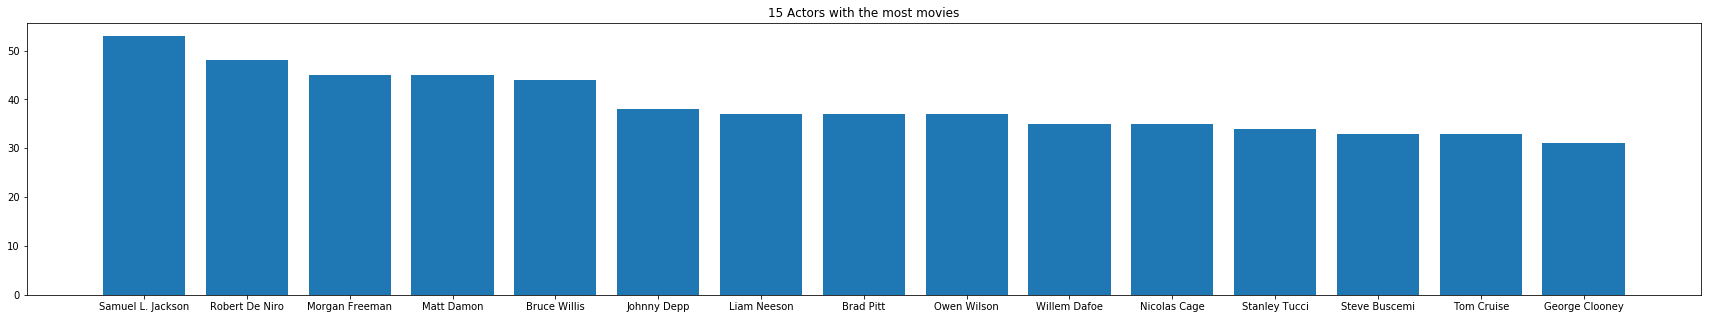

In [21]:
actors=people[people.type=='cast']
actors15=actors['name'].value_counts().nlargest(15)
plt.figure(figsize = (30,5))
plt.bar(actors15.index, height=actors15)
plt.title('15 Actors with the most movies')
plt.show()

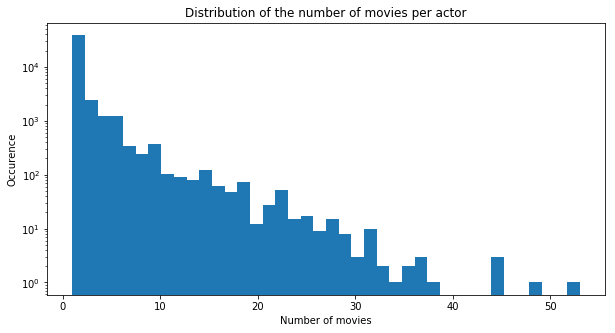

In [22]:
actors_tot=actors['name'].value_counts()
plt.figure(figsize = (10,5))
plt.hist(actors_tot, bins=40)
pl.gca().set_yscale("log")
plt.xlabel('Number of movies')
plt.ylabel('Occurence')
plt.title('Distribution of the number of movies per actor')
plt.show()

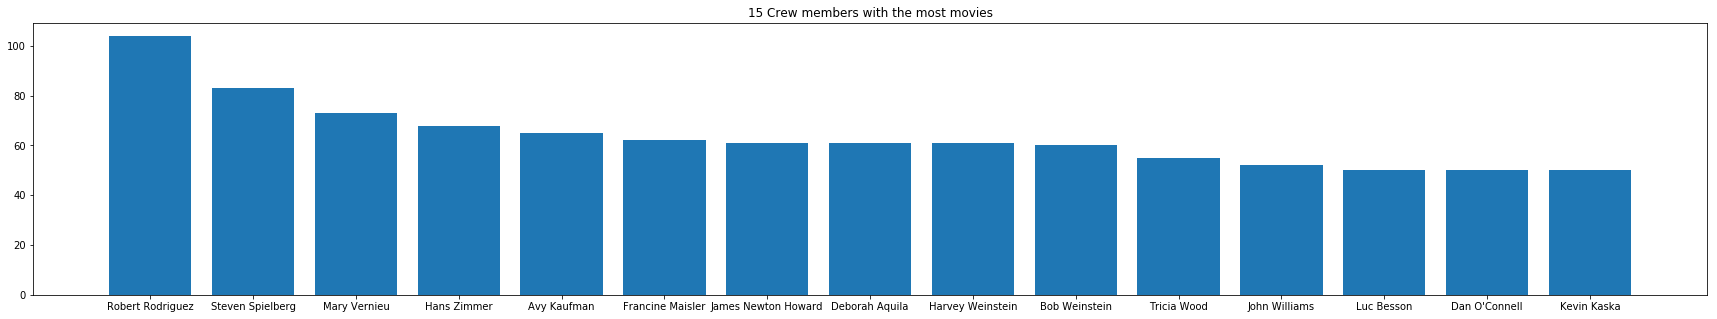

In [23]:
crew=people[people.type=='crew']
crew15=crew['name'].value_counts().nlargest(15)
plt.figure(figsize = (30,5))
plt.bar(crew15.index, height=crew15)
plt.title('15 Crew members with the most movies')
plt.show()

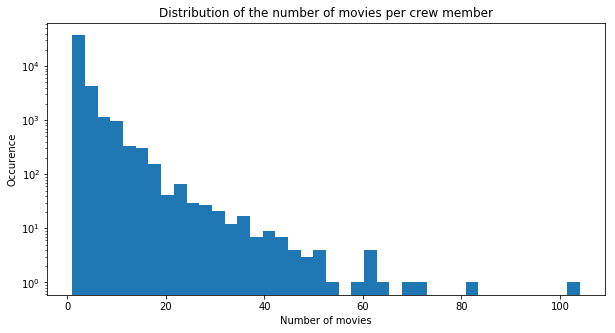

In [24]:
crew_tot=crew['name'].value_counts()
plt.figure(figsize = (10,5))
plt.hist(crew_tot, bins=40)
pl.gca().set_yscale("log")
plt.xlabel('Number of movies')
plt.ylabel('Occurence')
plt.title('Distribution of the number of movies per crew member')
plt.show()

We then realized that only a few of the ROI had high values (above 10), while the rest of the movies had values very close to 1, which created issues when we wanted to plot them. We thus filtered them.

In [25]:
print('The 10 largest ROI are \n {}'.format(movies['ROI'].nlargest(10)))
print('The number of ROI values which are larger than 10 is {}'.format(movies['ROI'][movies['ROI']>10].count()))
print('The average ROI is {}'.format(movies['ROI'].mean()))
print('The median ROI is {}'.format(movies['ROI'].median()))

The 10 largest ROI are 
 4577    12889.386667
4582     5329.339450
4496     4132.333333
4724      699.000000
4788      499.000000
4742      438.616585
4723      425.644100
4514      419.522723
3159      362.047059
4441      310.709965
Name: ROI, dtype: float64
The number of ROI values which are larger than 10 is 240
The average ROI is 11.737138980929341
The median ROI is 1.2990467222222222


In [26]:
filter_ROI=movies['ROI'].copy()
filter_ROI[filter_ROI>10]=10
movies['ROI']=filter_ROI

We created a list that allowed to make the conversion between the movies genres and the genre ID that we assigned them

In [27]:
list_genres=movies[['genres_names','genres']].copy()
list_genres=list_genres.drop_duplicates()
list_genres=list_genres.set_index('genres') 
list_genres

genres_names
genres                 
0                Action
1             Adventure
2               Fantasy
3             Animation
4       Science Fiction
5                 Drama
6              Thriller
7                Family
8                Comedy
9               History
10                  War
11              Western
12              Romance
13                Crime
14              Mystery
15               Horror
17                Music
16          Documentary
19              Unknown
20              Foreign

We plotted at the histograms for the budget, the revenue and the ROI, and observed that they all had tails-like distributions. Additionaly, for the ROI, it is important to note that a fair amount of movies havenegative values, meaning that had revenues that were smaller than their budget.

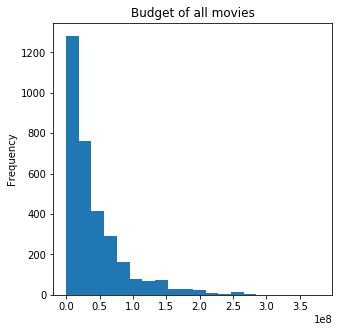

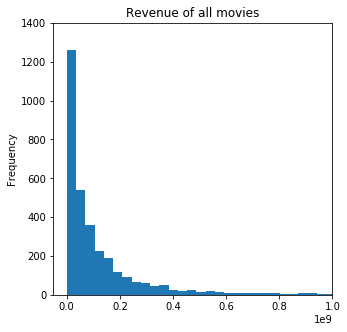

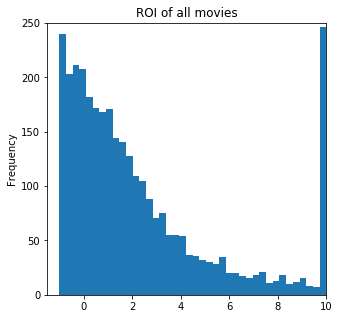

In [28]:
fig=plt.figure(figsize = (5,5))
movies.budget.plot(kind='hist', bins = 20)
plt.title('Budget of all movies')
plt.show()
fig.savefig('./pictures/budgets.png')

fig2=plt.figure(figsize = (5,5))
movies.revenue.plot(kind='hist', bins = 80)
plt.title('Revenue of all movies')
plt.axis([-0.05e9,1e9,0,1400])
plt.show()
fig2.savefig('./pictures/revenue.png')

fig3=plt.figure(figsize = (5,5))
movies.ROI.plot(kind='hist', bins = 40)
plt.title('ROI of all movies')
plt.axis([-1.5,10,0,250])
plt.show()
fig3.savefig('./pictures/roi.png')

We then looked at the different genres that we had, and looked at their repartition. We see that although their are 20 genres present in the dataset, only 7 genres have more than 100 movies. Drama, Comedy and Action represent 61% of the movies.

In [29]:
genres_count=movies['genres_names'].value_counts()
print(genres_count)

Drama              747
Comedy             634
Action             588
Adventure          288
Horror             197
Crime              141
Thriller           118
Animation           99
Fantasy             93
Science Fiction     79
Romance             70
Family              38
Documentary         30
Mystery             27
Western             22
Music               20
History             18
War                 18
Unknown              1
Foreign              1
Name: genres_names, dtype: int64


C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\matplotlib\legend.py:1266: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


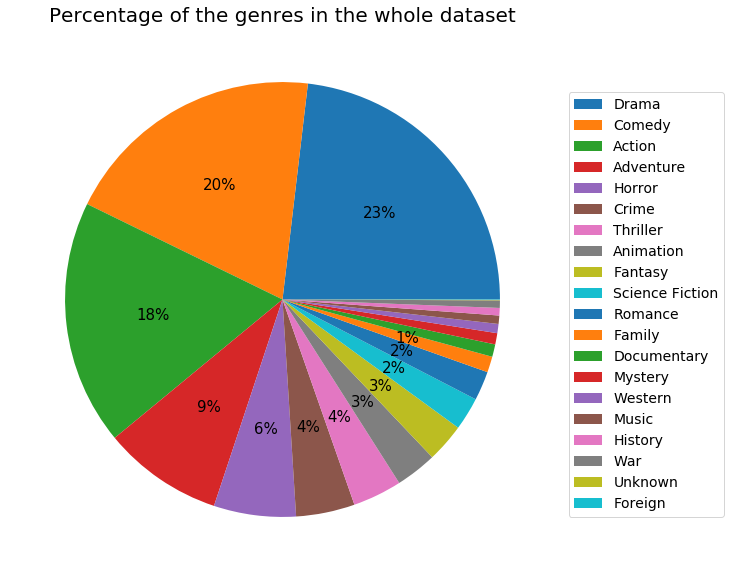

In [30]:
fig=plt.figure(figsize = (10,10))
plt.pie(genres_count, autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',labeldistance=1.1,startangle=0,textprops={'fontsize': 15})
plt.title('Percentage of the genres in the whole dataset',fontsize=20)
plt.legend(genres_count,labels=movies['genres_names'].value_counts().index, bbox_to_anchor=(0.9,0.80), bbox_transform=plt.gcf().transFigure,prop={'size': 14})
plt.show()
fig.savefig('./pictures/pie.png')

We looked in details at the different production companies, the number of movies that they were responsible and their ROI.

In [31]:
production_companies = []
movies.apply(lambda row: [x.update({'id': row['id']}) for x in row['production_companies']], axis=1);

movies.production_companies.apply(lambda x: production_companies.extend(x))
production_companies = pd.DataFrame(production_companies)

production_companies['type'] = 'production_companies'
production_companies=production_companies.drop_duplicates('id')
production_companies['index']=production_companies['id']
production_companies=production_companies.set_index('id') 

list_of_companies=production_companies['name'].unique()
nb_companies=len(list_of_companies) # there are 753 production companies
companies_names=production_companies['name'].copy()

movies['companies_names']=companies_names
factorized_names_companies = pd.factorize(movies['companies_names'])[0]

movies['production_companies']=factorized_names_companies

#the list that makes the conversion between companies names and their id
list_companies=movies[['companies_names','production_companies']].copy()
list_companies=list_companies.drop_duplicates()
list_companies['id']=list_companies['production_companies']
list_companies=list_companies.set_index('production_companies') 

data_companies=movies['companies_names'].value_counts().tolist()

data_companies=pd.DataFrame(data_companies)
list_companies['number_film']=data_companies
list_companies
data_companies_relevent=movies['companies_names'].value_counts()
data_companies_relevent=data_companies_relevent[(data_companies_relevent> 30)]
data_companies_relevent

list_companies=list_companies.assign(ROI_TOT=0)
   
for i in range(0,753):
    list_companies.at[i, 'ROI_TOT'] =sum(movies[movies['production_companies'] == i]['ROI'])


print('Their are {} different production companies'.format(list_companies.shape[0]))
list_companies.head(3)


Their are 754 different production companies


companies_names  id  number_film  ROI_TOT
production_companies                                                   
0                     Ingenious Film Partners   0        241.0       34
1                        Walt Disney Pictures   1        228.0      216
2                           Columbia Pictures   2        166.0      311

Although their are 754 production companies in the dataset, we see that only four of them are responsible for 52% of the movies

C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\matplotlib\legend.py:1266: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


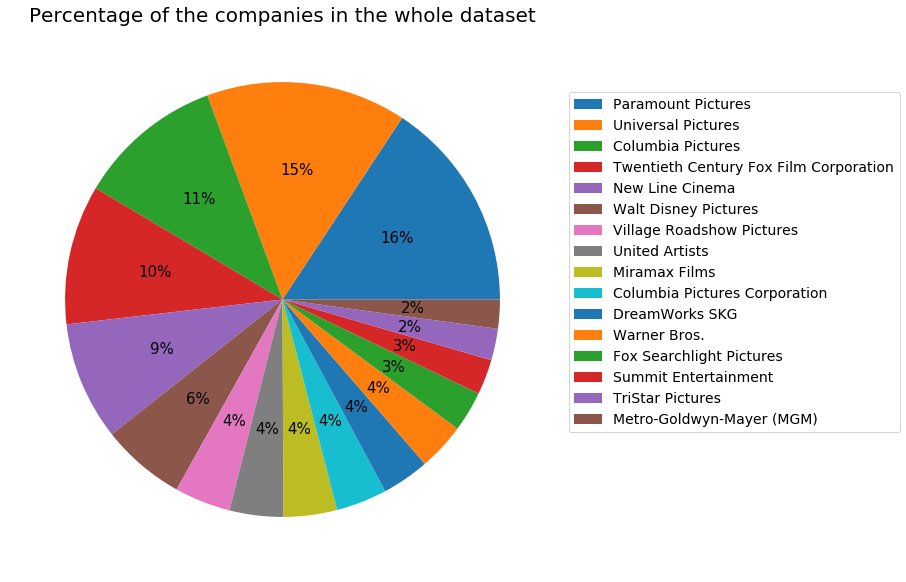

In [32]:
plt.figure(figsize = (10,10))
plt.pie(data_companies_relevent, autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',labeldistance=1.1,startangle=0,textprops={'fontsize': 15})
plt.title('Percentage of the companies in the whole dataset',fontsize=20)
plt.legend(data_companies_relevent,labels=movies['companies_names'].value_counts().index, bbox_to_anchor=(0.9,0.80), bbox_transform=plt.gcf().transFigure,prop={'size': 14})
plt.show()

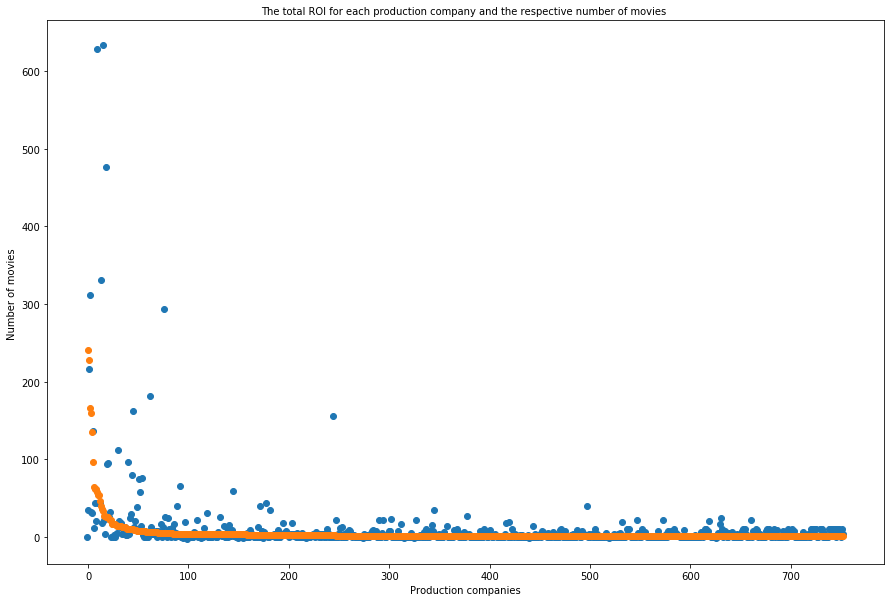

In [33]:
plt.figure(figsize=(15, 10))
plt.scatter(list_companies['id'],list_companies['ROI_TOT'])
plt.scatter(list_companies['id'],list_companies['number_film'])
plt.title('The total ROI for each production company and the respective number of movies ',fontsize=10);
plt.xlabel('Production companies')
plt.ylabel('Number of movies ')
plt.show()

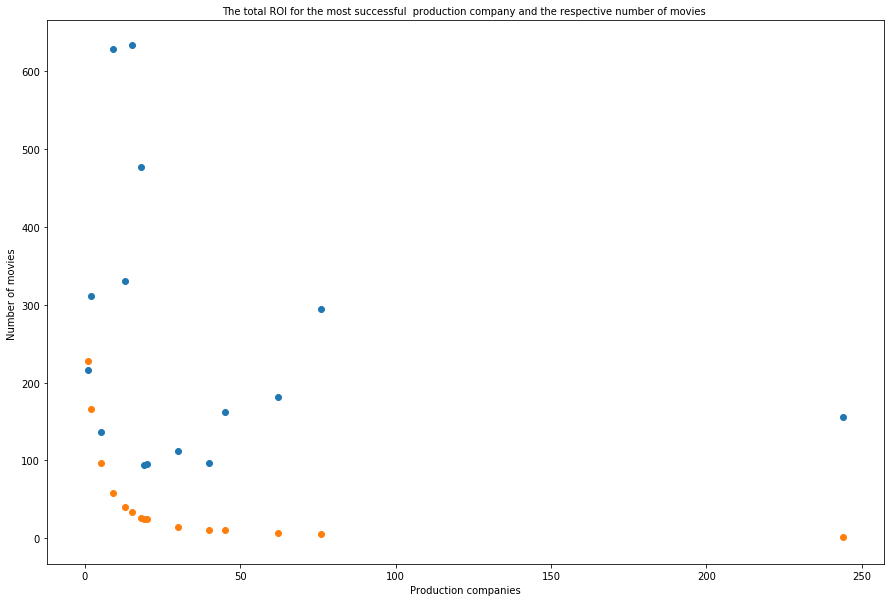

In [34]:
list_companies_succesful=list_companies[list_companies['ROI_TOT'] >80]

plt.figure(figsize=(15, 10))

plt.scatter(list_companies_succesful['id'],list_companies_succesful['ROI_TOT'])
plt.scatter(list_companies_succesful['id'],list_companies_succesful['number_film'])
plt.title('The total ROI for the most successful  production company and the respective number of movies ',fontsize=10);
plt.xlabel('Production companies')
plt.ylabel('Number of movies ')
plt.show()

## 2 - Create the feature matrix and a graph using the actors

We wanted to create a graph of movies by connecting them if they had similar actors. For that we created a function that uses the movies and the people dataframes, and return a dataframe with one row for each person. The first three columns contain the ID of the person, their name and the average rating of all their movies. Then their are 3229 columns, one for each movie, and the value of a cell is equal to 1 if the person worked on this movie (either as a cast or a crew), and 0 if the person did not. For this, we only kept the people that had worked on at least 5 movies, leaving us with 7940 people only. This was done to encure that our  graph would not be fully connected.

In [35]:
#Used to create a new feature matrix
#As the function takes some time to run, we saved the feature matrix and are simply loading it.
#features_actors=ldata.create_features(movies,people);
features=pd.read_csv('./data/test_actors_crew.csv')
features = features.drop(features.columns[0],axis=1)
print(features.shape)
features.head(3)

(7940, 3232)


id           name  Average_Rating  Movie_ID_0  Movie_ID_1  Movie_ID_2  \
0   1   George Lucas        6.952941           0           0           0   
1   3  Harrison Ford        6.706452           0           0           0   
2   4  Carrie Fisher        6.485714           0           0           0   

   Movie_ID_3  Movie_ID_4  Movie_ID_5  Movie_ID_6      ...        \
0           0           0           0           0      ...         
1           0           0           0           0      ...         
2           0           0           0           0      ...         

   Movie_ID_4738  Movie_ID_4742  Movie_ID_4752  Movie_ID_4758  Movie_ID_4772  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   

   Movie_ID_4773  Movie_ID_4788  Movie_ID_4792  Movie_ID_4796  Movie_ID_4798  
0              0              0              0              0              0  
1              0              0              0              0              0  
2              0              0              0              0              0  

[3 rows x 3232 columns]

Then we created an adjacency matrix that links movies with actors and crew in common, however they need to have more than 1 person in common, to avoid a fully conected graph. The weight of the edges is equal to the number of people in common. We also did the same thing but using only the actors and not the crew. Both adjacency matrices are shown below.

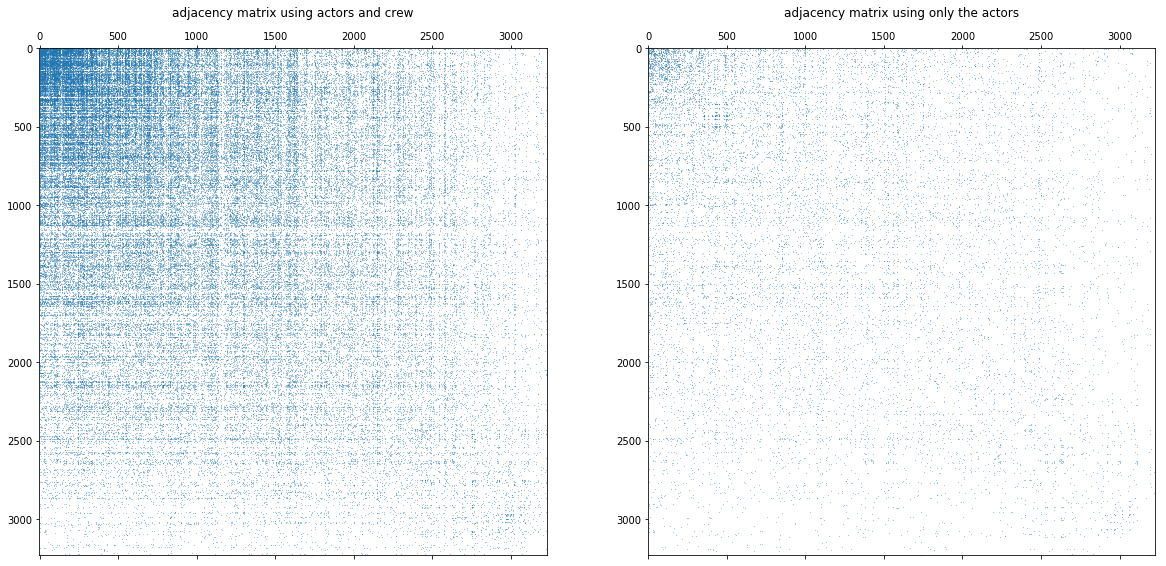

In [36]:
#As both function used to create the adjacency take some time to run, we saved the adjacency and simply load it.

#Used to load the feature dataframe from a file, remove the useless columns and transpose it.
#features_movies=ldata.load_features();

#Used to create the adjacency matrix from the features
#As the function takes some time to run, we saved the adjacency matrix and are simply loading it.
#adjacency_test=ldata.make_adjacency_from_feature_matrix(features_movies)


plt.figure(figsize=(20, 10))

plt.subplot(121)
adjacency_actors_crew=np.load('./data/adjacency_actors_crew.npy')
plt.spy(adjacency_actors_crew, markersize=0.1)
plt.title('adjacency matrix using actors and crew');

plt.subplot(122)
adjacency_actors_crew=np.load('./data/adjacency_actors_only.npy')
plt.spy(adjacency_actors_crew, markersize=0.1)
plt.title('adjacency matrix using only the actors');
plt.show()

For the rest of the project, we decided to use the adjacency matrix with actors and the crew, however as both adjacency matrices were saved they can be easily swapped if needed. We then created a graph using this adjacency matrix. As shown below, there are many unconnected movies (338 connected componenents in total), so we decided to use the giant component for the next steps.

The number of connected components is 338


C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


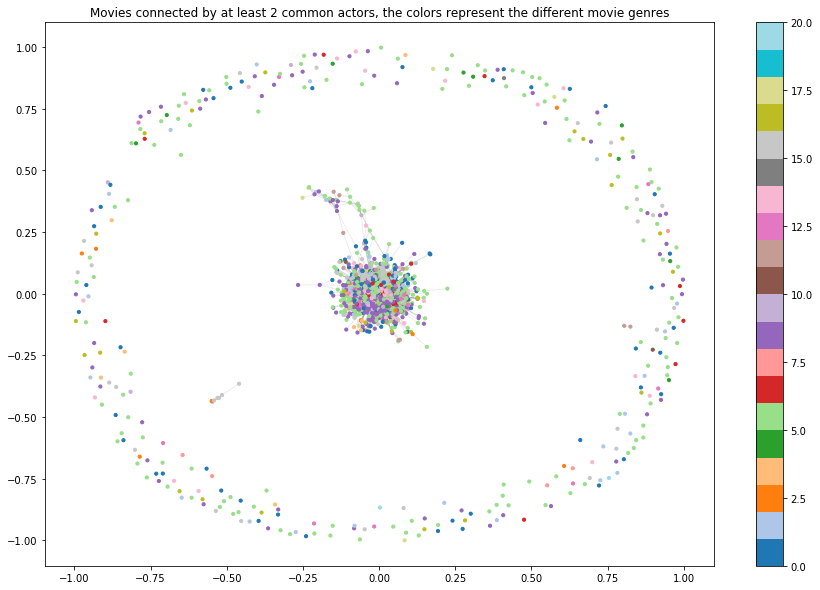

In [37]:
#We decided to use the adjacency with actors and the crew, but the one with actors only can be used if needed.
#adjacency_actors=np.load('./data/adjacency_actors_only.npy')
adjacency_actors=np.load('./data/adjacency_actors_crew.npy')

G = nx.from_numpy_matrix(adjacency_actors)
print('The number of connected components is {}'.format(nx.number_connected_components(G)))
coords = nx.spring_layout(G,k=0.03)  # Force-directed layout.
labels = movies['genres'].iloc[np.sort(nx.nodes(G))]

fig=plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(G, coords, node_size=10,node_color=labels, cmap='tab20',vmin=0, vmax=20)
nx.draw_networkx_edges(G, coords, alpha=0.1, width=0.7)
plt.title('Movies connected by at least 2 common actors, the colors represent the different movie genres')
plt.colorbar(im);
fig.savefig('./pictures/graph1.png')

We plot the giant component and see that it contains 2883 movies. We also plot it with only the three most represented movie genres (Action, Drama and Comedy)

The number of nodes is is 2883


C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


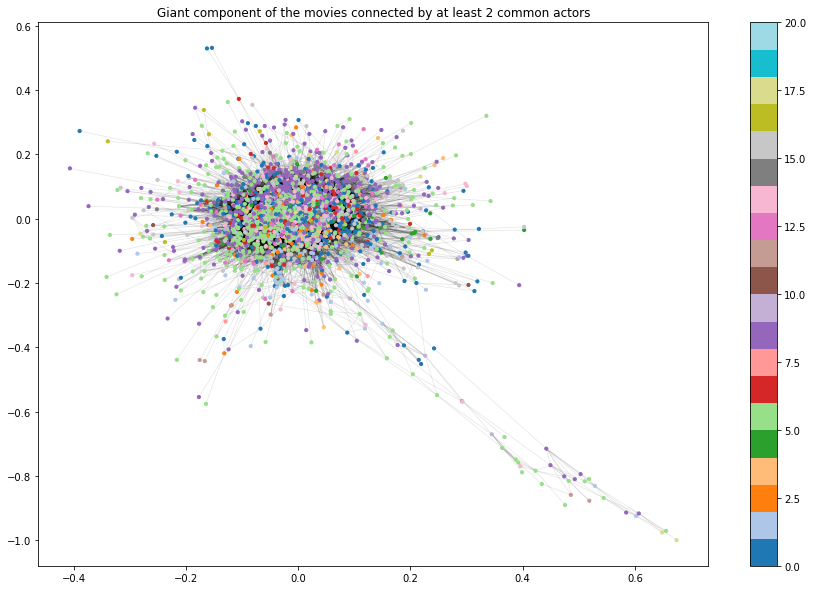

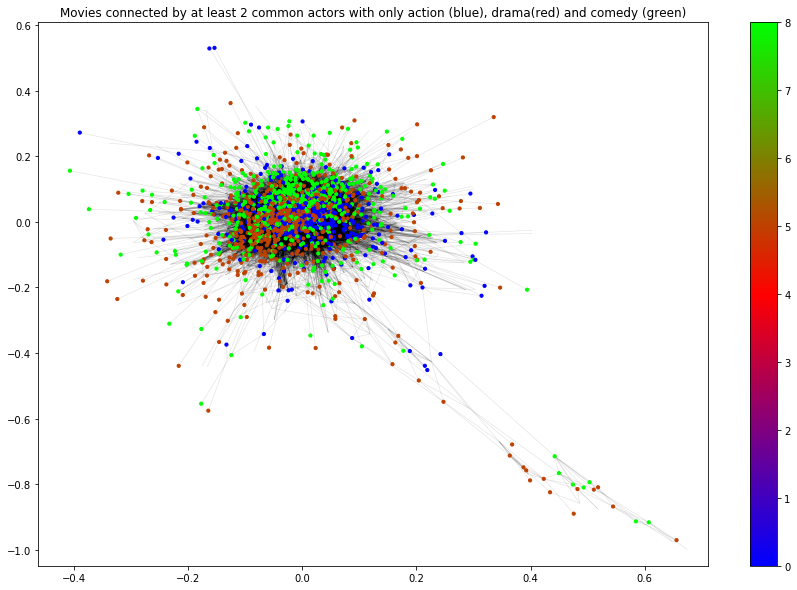

In [38]:
Gc = max(nx.connected_component_subgraphs(G), key=len)
coords_Gc = nx.spring_layout(Gc,k=0.03)  # Force-directed layout.

print('The number of nodes is is {}'.format(Gc.number_of_nodes()))
labels = movies['genres'].iloc[np.sort(nx.nodes(Gc))]
fig=plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(Gc, coords_Gc, node_size=10,node_color=labels, cmap='tab20',vmin=0, vmax=20)
nx.draw_networkx_edges(Gc, coords_Gc, alpha=0.1, width=0.7)
plt.title('Giant component of the movies connected by at least 2 common actors')
plt.colorbar(im);
fig.savefig('./pictures/graph1.png')

#We mask the movies which do no belong to the 3 most represented genres
masked_labels=labels.copy()
masked_labels[masked_labels<30]=30
masked_labels[labels==0]=0
masked_labels[labels==5]=5
masked_labels[labels==8]=8
masked_labels[masked_labels>10]=np.nan

#action = 0 = blue
#drama = 5 = red
#comedy = 8= green

fig2=plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(Gc, coords_Gc, node_size=10,node_color=masked_labels, cmap='brg',vmin=0, vmax=8)
nx.draw_networkx_edges(Gc, coords_Gc, alpha=0.1, width=0.7)
plt.title('Movies connected by at least 2 common actors with only action (blue), drama(red) and comedy (green)')
plt.colorbar(im);
fig2.savefig('./pictures/graph2.png')


We can then use this graph to represen different signal, for example the average rating of each movie, or the success rate.
As seen on both graphs below, there are no distinct communities of movies that are grouped with the same rating or success rate.

C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


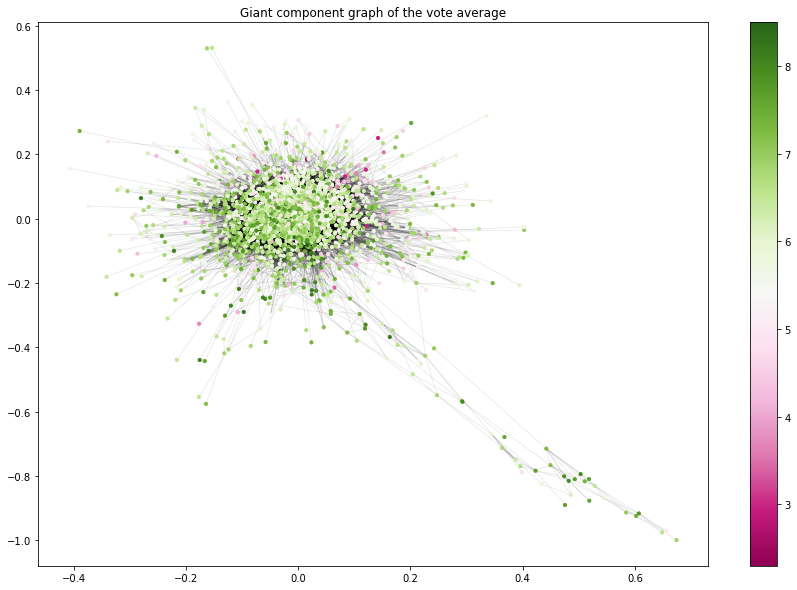

In [39]:
labels = movies['vote_average'].iloc[np.sort(nx.nodes(Gc))]
plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(Gc, coords_Gc, node_size=10,node_color=labels, cmap='PiYG')
nx.draw_networkx_edges(Gc, coords_Gc, alpha=0.1, width=0.7)
plt.title('Giant component graph of the vote average')
plt.colorbar(im);

C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


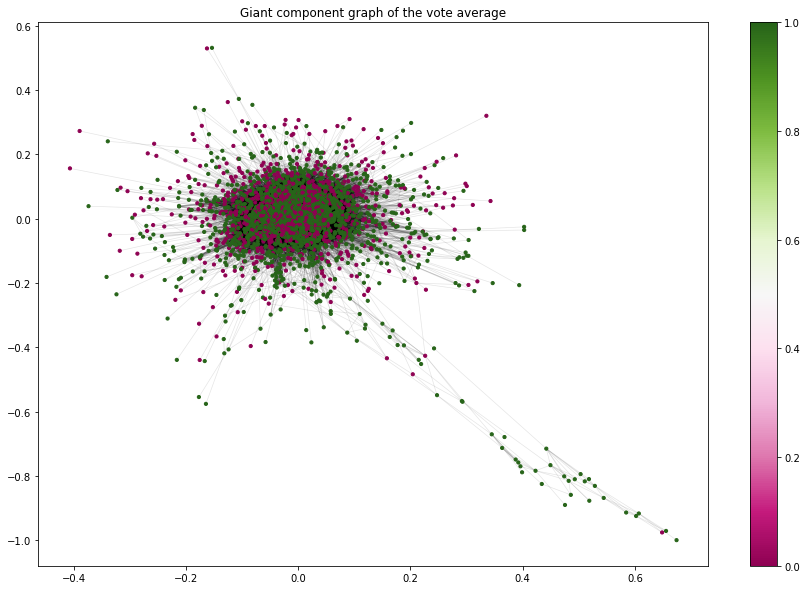

In [40]:
labels = movies['success'].iloc[np.sort(nx.nodes(Gc))]
plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(Gc, coords_Gc, node_size=10,node_color=labels, cmap='PiYG')
nx.draw_networkx_edges(Gc, coords_Gc, alpha=0.1, width=0.7)
plt.title('Giant component graph of the vote average')
plt.colorbar(im);

## 3 - Separation into decades

Our initial idea was to look at the evolution of the movie industry throughout the years. For that, we split the dataset into 6 different subset, one from each decade, from 1960 to 2020. As there was only a few movies from before 1960 in the dataset, we decided not to use them.

In [41]:
numberOfDecades = 6

moviesFilteredByYears = []

for i in range(numberOfDecades):
    decade = 1960 + i*10
    decadeEnd = decade + 10
    moviesFilteredByYears.append(ldata.filter_movies_by_years(movies, pd.to_datetime(f'{decade}-01-01').date(), pd.to_datetime(f'{decadeEnd}-01-01').date()))

We created the same graphs, connecting movies that have actors or crew in common, but for each decade. This was achieved by keeping only the desired rows and columns of the complete adjacency matrix. Below are shown the 6 different adjacency matrices, the corresponding complete graphs and giant component graphs. We see that the number of movies increases with each deacde (with the exception of 2010-2020, since it is not over yet)

C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab

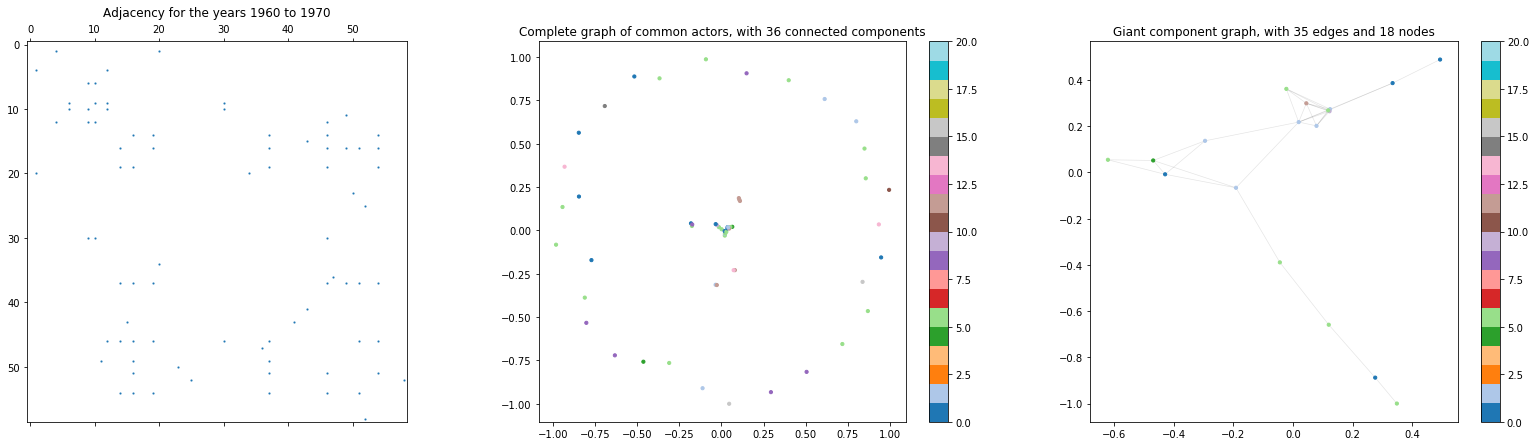

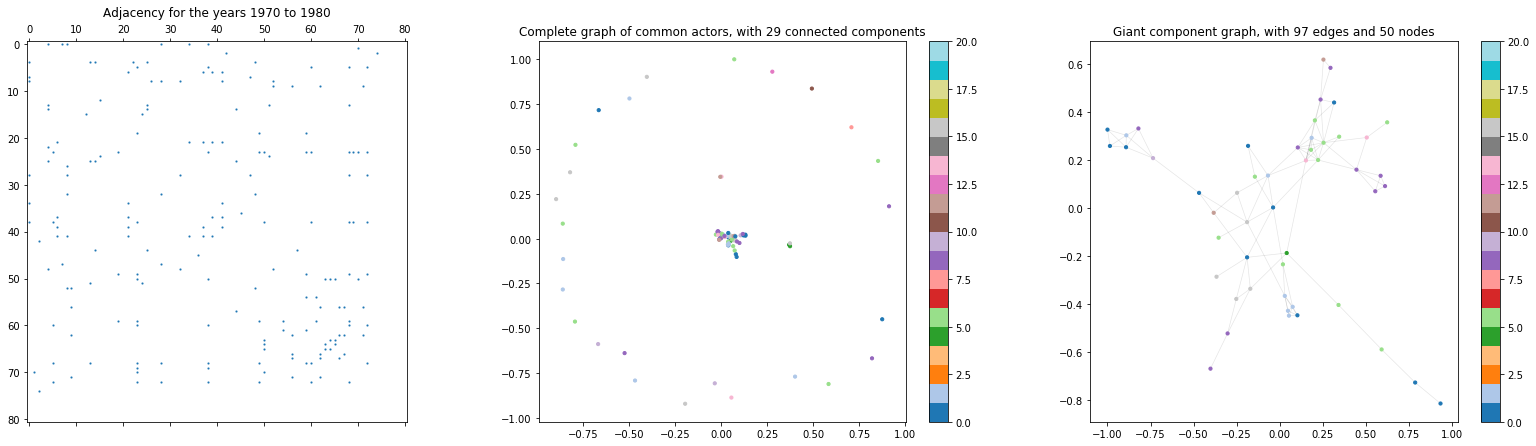

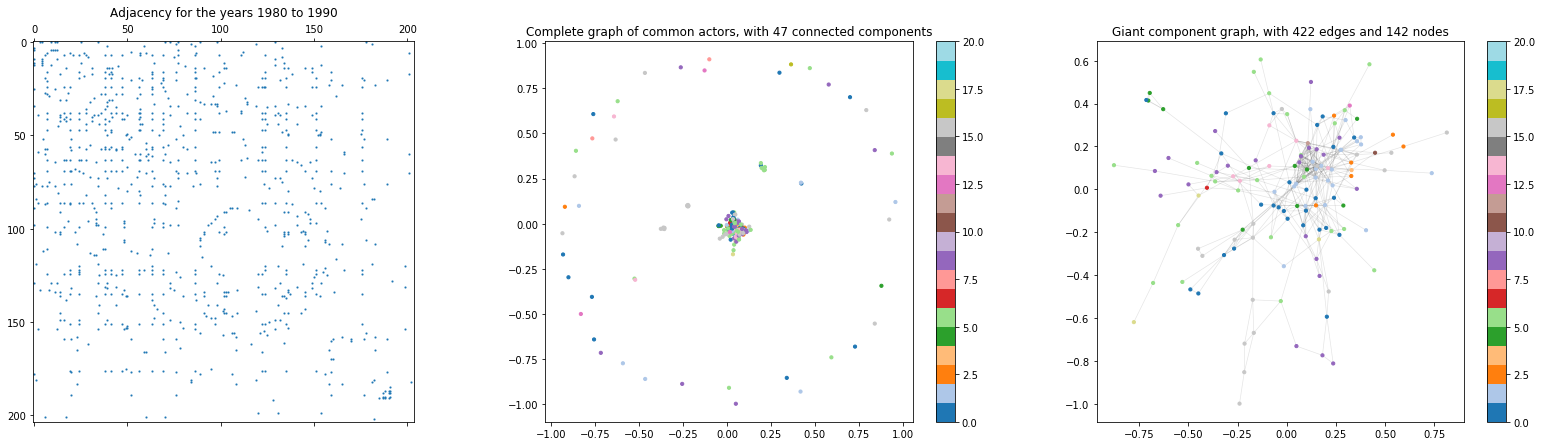

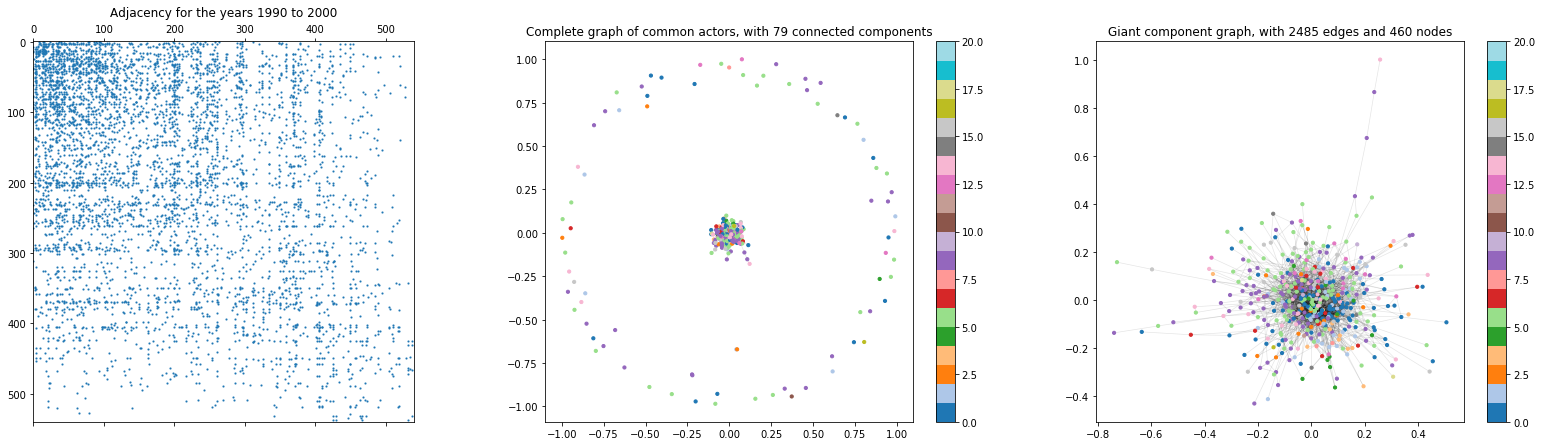

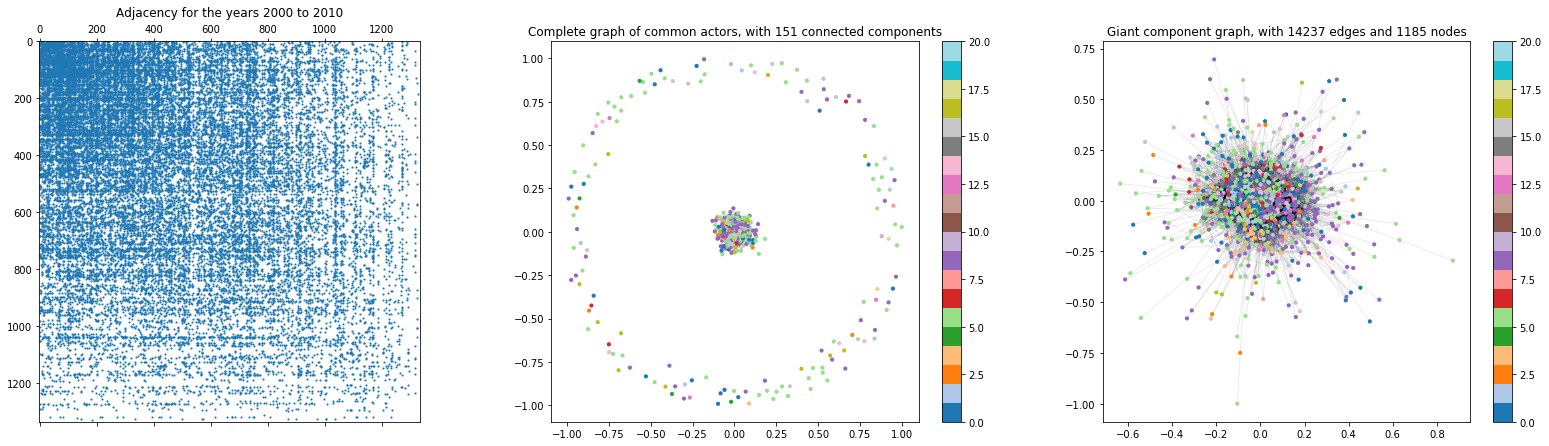

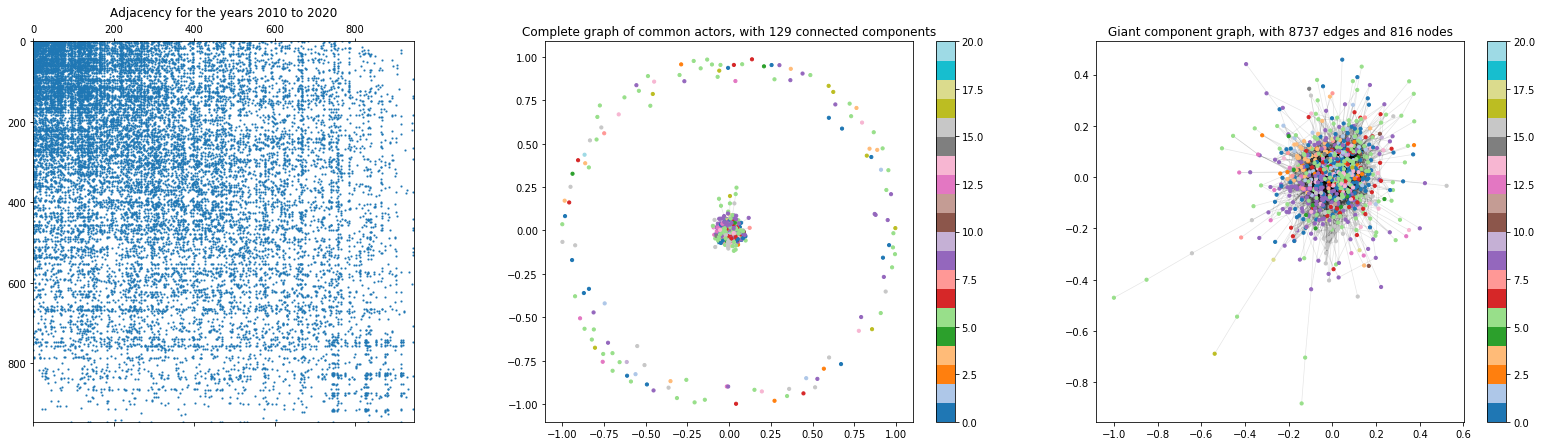

In [42]:
adjacency=np.load('./data/adjacency_actors_crew.npy')
moviesFilteredByYears
for i in range(numberOfDecades):
    
    decade = 1960 + i*10
    decadeEnd = decade + 10
    
    #We filter the entire adjacency matrix, by keeping only the rows and columns corresponding to the movies in the decade.
    id_to_keep=moviesFilteredByYears[i].index
    adjacency_id= movies.loc[:, ['id']]
    adjacency_id['id_order']=np.arange(movies.shape[0])
    adjacency_id=adjacency_id.loc[adjacency_id['id'].isin(id_to_keep)]
    
    lines_to_keep=adjacency_id['id_order']
    adjacency_tot=adjacency.copy()
    adjacency_decade_filtered=adjacency_tot[lines_to_keep,:]
    adjacency_decade_filtered=adjacency_decade_filtered[:,lines_to_keep]
    
    plt.figure(figsize=(28, 7))
    plt.subplot(131)
    plt.spy(adjacency_decade_filtered, markersize=1)
    plt.title('Adjacency for the years {} to {}'.format(decade, decadeEnd))
    
    G_decade = nx.from_numpy_matrix(adjacency_decade_filtered)
    coords_decade = nx.spring_layout(G_decade,k=0.03)  
    labels = moviesFilteredByYears[i]['genres'].iloc[np.sort(nx.nodes(G_decade))]
    
    plt.subplot(132)
    im=nx.draw_networkx_nodes(G_decade, coords_decade, node_size=10,node_color=labels, cmap='tab20',vmin=0, vmax=20)
    nx.draw_networkx_edges(G_decade, coords_decade, alpha=0.1, width=0.7)
    plt.title('Complete graph of common actors, with {} connected components'.format(nx.number_connected_components(G_decade)))
    plt.colorbar(im);
    
    Gc_decade = max(nx.connected_component_subgraphs(G_decade), key=len)
    nb_edges_gc=Gc_decade.number_of_edges()
    nb_nodes_gc=Gc_decade.number_of_nodes()
    coords_decade_Gc = nx.spring_layout(Gc_decade,k=0.03)  
    labels = moviesFilteredByYears[i]['genres'].iloc[np.sort(nx.nodes(Gc_decade))]
    
    plt.subplot(133)
    im=nx.draw_networkx_nodes(Gc_decade, coords_decade_Gc, node_size=10,node_color=labels, cmap='tab20',vmin=0, vmax=20)
    nx.draw_networkx_edges(Gc_decade, coords_decade_Gc, alpha=0.1, width=0.7)
    plt.title('Giant component graph, with {} edges and {} nodes'.format(nb_edges_gc,nb_nodes_gc))
    plt.colorbar(im);

Then, we used the budget and the revenue of the movies, to make additional adjacency matrices for each decade. We built them in our function "make_budget_based_adjacency", using similarities between the budget and genres. Then all the graphs and adjacency matrices are stocked for later use. We also show the weights distribution that are used to build the 6 different adjacency matrices.

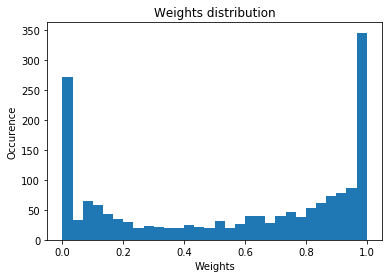

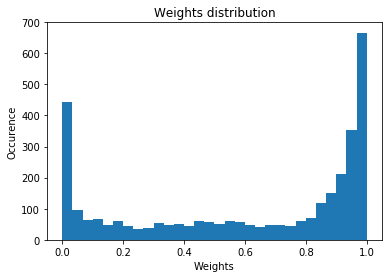

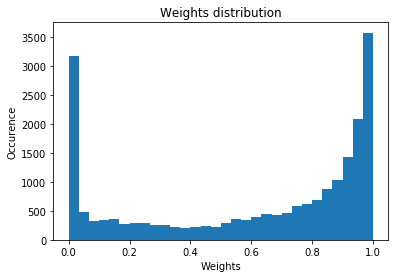

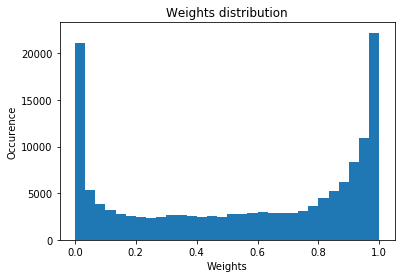

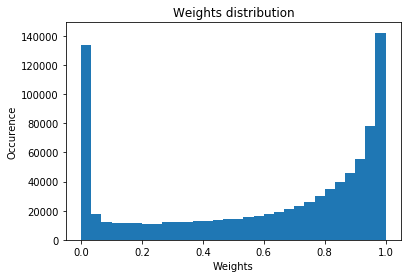

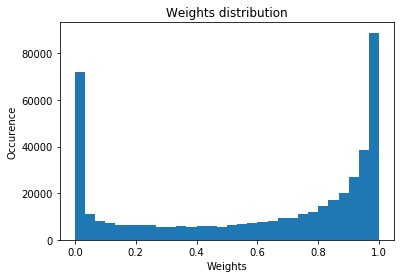

In [43]:
#We append the information for each decade
adjacenciesFilteredByYears = []
moviesByBudgetFilteredByYears = []
graphsFilteredByYears = []

for moviesData in moviesFilteredByYears:
    (adjacency, moviesByBudget) = ldata.make_budget_based_adjacency(moviesData);
    adjacenciesFilteredByYears.append(adjacency);
    moviesByBudgetFilteredByYears.append(moviesByBudget)
    graphsFilteredByYears.append(pg.graphs.Graph(adjacency))

In [44]:
voteAvrgFtFilteredByYears = []
voteAvrgFilteredByYears = []

for i in range(len(graphsFilteredByYears)):
    voteAvrgFilteredByYears.append((moviesByBudgetFilteredByYears[i])['vote_average'].copy())
    (graphsFilteredByYears[i]).compute_fourier_basis()
    voteAvrgFtFilteredByYears.append(graphsFilteredByYears[i].gft((voteAvrgFilteredByYears[i]).values))

Now that we have filter our movies by decades, we can look at the correlation between the budget, the revenue, the vote average, the popularity and the return of investments. By plotting one correlation heatmap per decade, we can observe how the correlation evolved over the years.

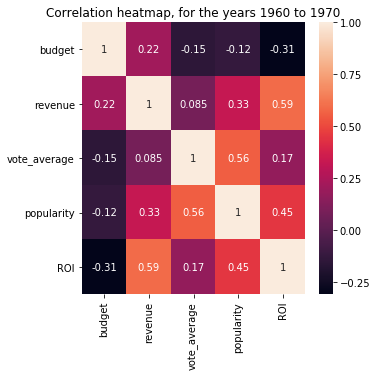

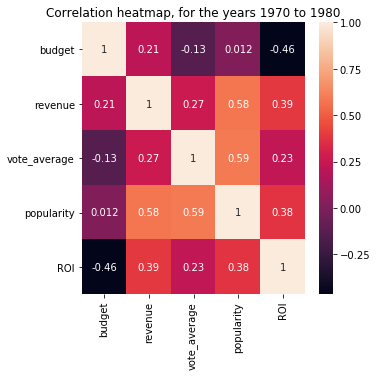

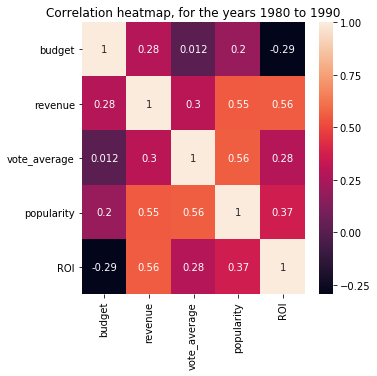

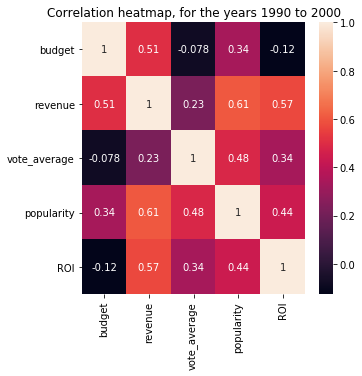

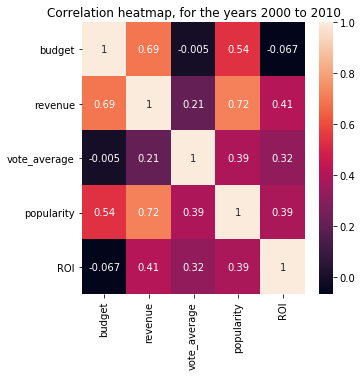

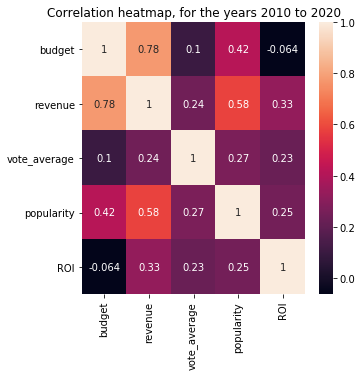

In [45]:
for i in range(len(graphsFilteredByYears)):
    decade = 1960 + i*10
    decadeEnd = decade + 10
    plt.figure(figsize=(5, 5))
    plt.title('Correlation heatmap, for the years {} to {}'.format(decade,decadeEnd))
    data= moviesByBudgetFilteredByYears[i].loc[:, ['budget', 'revenue','vote_average','popularity','ROI']]
    sns.heatmap(data=data.corr(),annot=True)

We also wanted to see if there was a more general correlation over the years between the revenue and the budget of movies and the global economy.
In the following section, we will try to visualize the **evolution in the average revenue** of the movies through years.

In [46]:
nb_movies = movies['release_date'].values.shape[0]

#creating a matrix containing the movie's year and its revenue and budget.
rev_per_year = np.zeros((nb_movies,4))
for i in range(nb_movies):
    rev_per_year[i,0]=movies['release_date'].values[i].year
    rev_per_year[i,1]=movies['revenue'].values[i]
    rev_per_year[i,2]=movies['budget'].values[i]
    rev_per_year[i,3]=movies['ROI'].values[i]

years = np.unique(rev_per_year[:,0])
average_rev_per_year = np.zeros((years.shape[0],4))

#taking the average revenue of all the movies filmed in the same year
rev=0
bud=0
roi=0
for j in range(years.shape[0]):
    n = 0
    for i in range(nb_movies):
        if rev_per_year[i,0] == years[j] and ~np.isnan(rev_per_year[i,0]):
            rev = rev+rev_per_year[i,1]
            bud = bud+rev_per_year[i,2]
            roi = roi+rev_per_year[i,3]
            n = n+1
    average_rev_per_year[j,0]=years[j]
    average_rev_per_year[j,1]= rev/n
    average_rev_per_year[j,2]= bud/n
    average_rev_per_year[j,3]= roi/n

#removing the last nan row
average_rev_per_year=average_rev_per_year[:-2,:]

Now we can try to see if there is any correlation between the economy (here represented by the **S&P500** (index representing the 500 largest US companies) average yearly value) and the movies universe. The question we're trying to answer is if the economic crisis affect the movies industry or not.
The historical data of S&P 500 (index GSPC) will be recuperated via Yahoo finance.

In [47]:
#The GSPC cvs file was recuperated via Yahoo finance
gspc=pd.read_csv('./data/GSPC.csv')
gspc_av_yearlyclose = np.zeros((2017-1950+1,2))
for i in range(gspc_av_yearlyclose.shape[0]):
    gspc_av_yearlyclose[i,0]=1950+i
    gspc_av_yearlyclose[i,1]=np.mean(gspc['Close'].values[12*(i+1)-12:12*(i+1)])

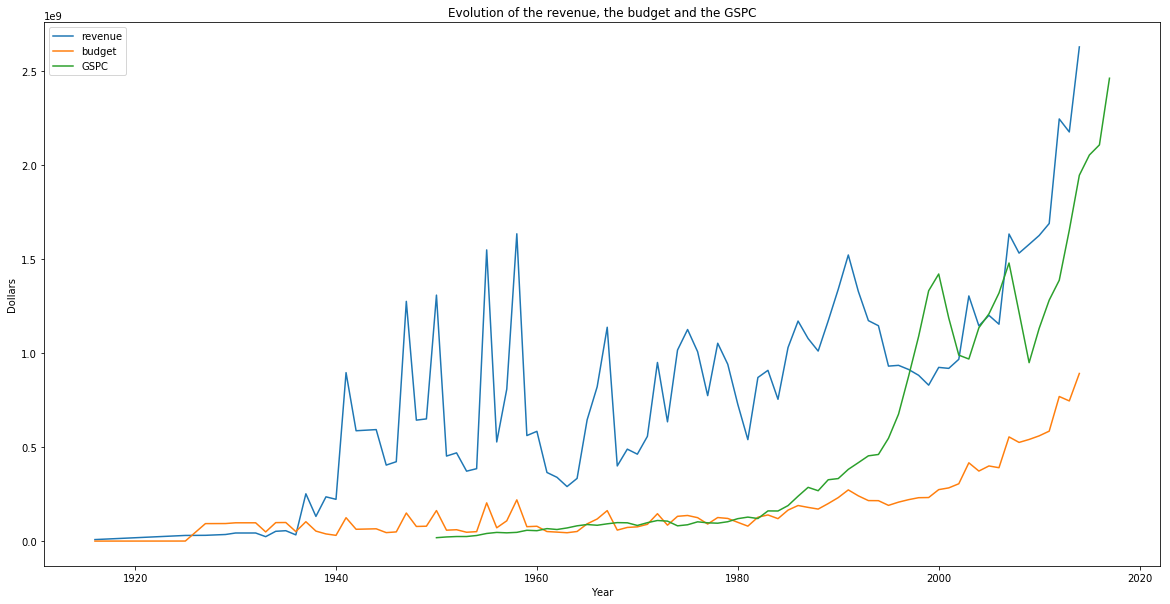

In [48]:
plt.figure(figsize=(20, 10))
plt.title('Evolution of the revenue, the budget and the GSPC')
plt.xlabel('Year')
plt.ylabel('Dollars')
plt.plot(average_rev_per_year[:,0],average_rev_per_year[:,1], label='revenue')
plt.plot(average_rev_per_year[:,0],average_rev_per_year[:,2], label='budget')
plt.plot(gspc_av_yearlyclose[:,0],gspc_av_yearlyclose[:,1]*1000000, label='GSPC')
plt.legend(loc='upper left')
plt.show()

In [49]:
np.corrcoef(average_rev_per_year[-50:,1],gspc_av_yearlyclose[-50:,1])

array([[1.        , 0.75067377],
       [0.75067377, 1.        ]])

Now let's go back to the adjacency matrices of each decade
We now create the coordinates of the budget and revenue based graphs, and the coordinates of their giant components. Below are shown the 6 different adjacency matrices, the corresponding complete graphs and giant component graphs. We see that the number of movies increases with each deacde (with the exception of 2010-2020, since it is not over yet). As expected from such graphs based on distances, they have have long shapes.

In [50]:
i = 0
GCgraphsFilteredByYears=[]
GgraphsFilteredByYears=[]
CoordsGcSpringFilteredByYears=[]
CoordsSpringFilteredByYears=[]

for G in graphsFilteredByYears:  
    #Creation of the coordinate of all the graphs and their giant components
    full_G = nx.from_numpy_matrix(adjacenciesFilteredByYears[i])
    GgraphsFilteredByYears.append(full_G)
    Gc = max(nx.connected_component_subgraphs(full_G), key=len)
    GCgraphsFilteredByYears.append(Gc)
    CoordsGcSpringFilteredByYears.append(nx.spring_layout(Gc,k=0.03))
    CoordsSpringFilteredByYears.append(nx.spring_layout(full_G,k=0.03))
    i = i+1

C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab

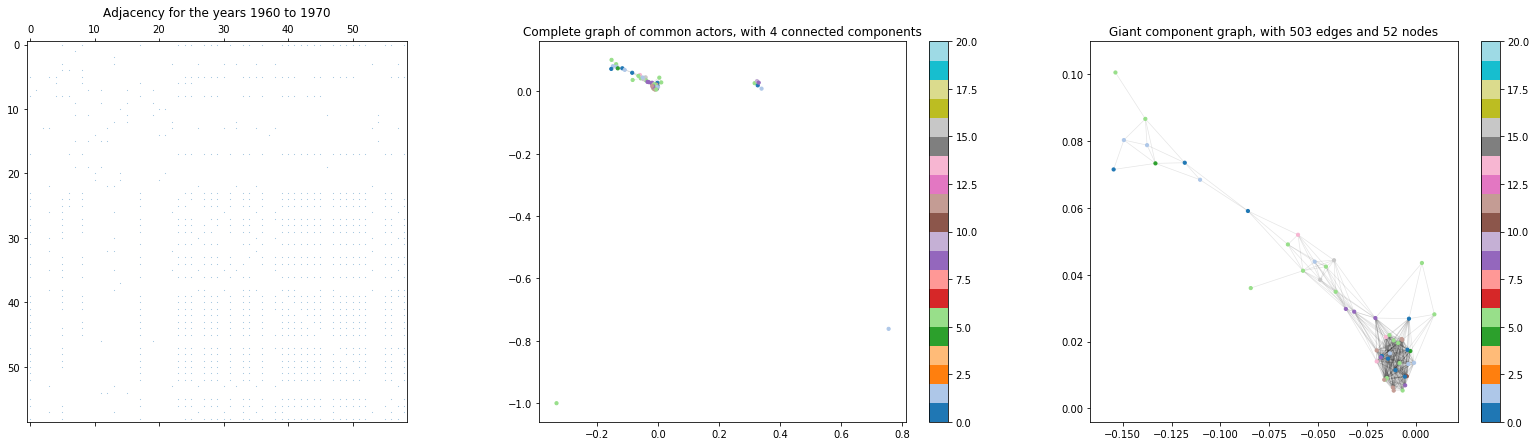

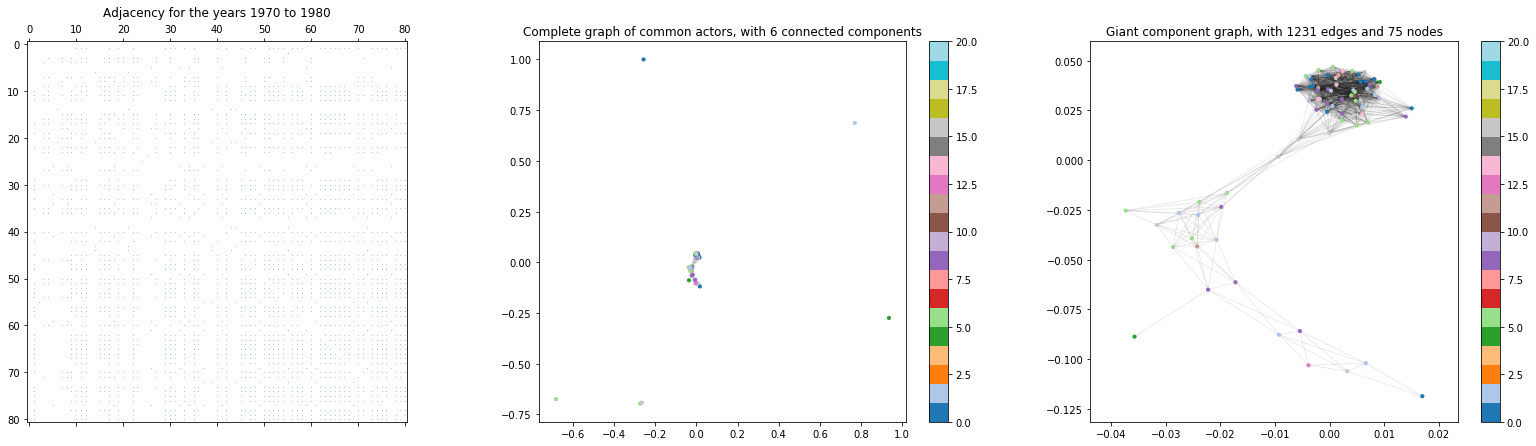

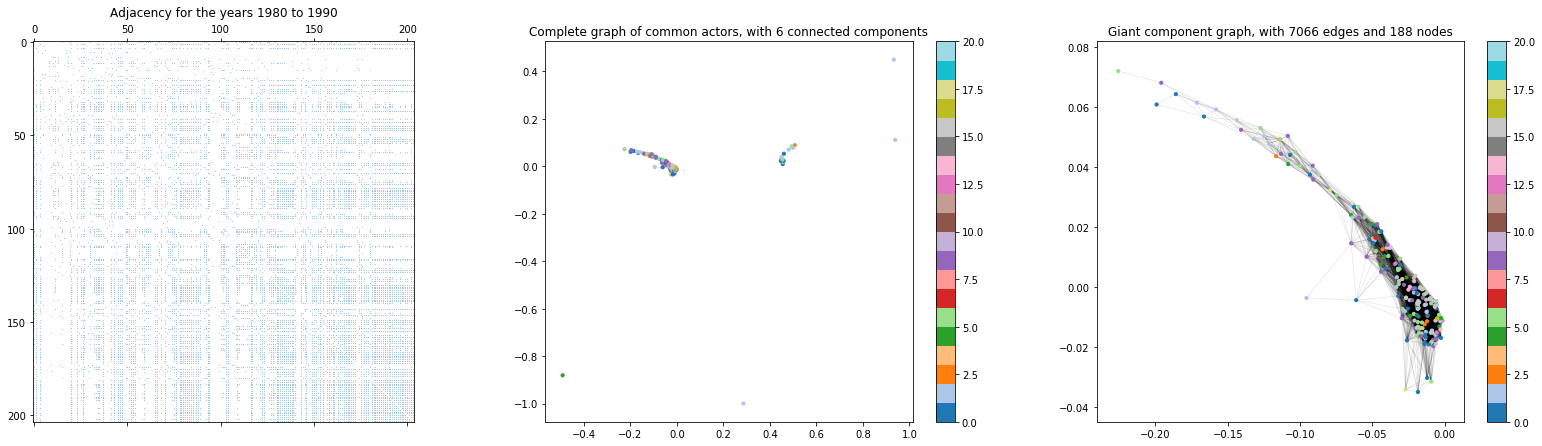

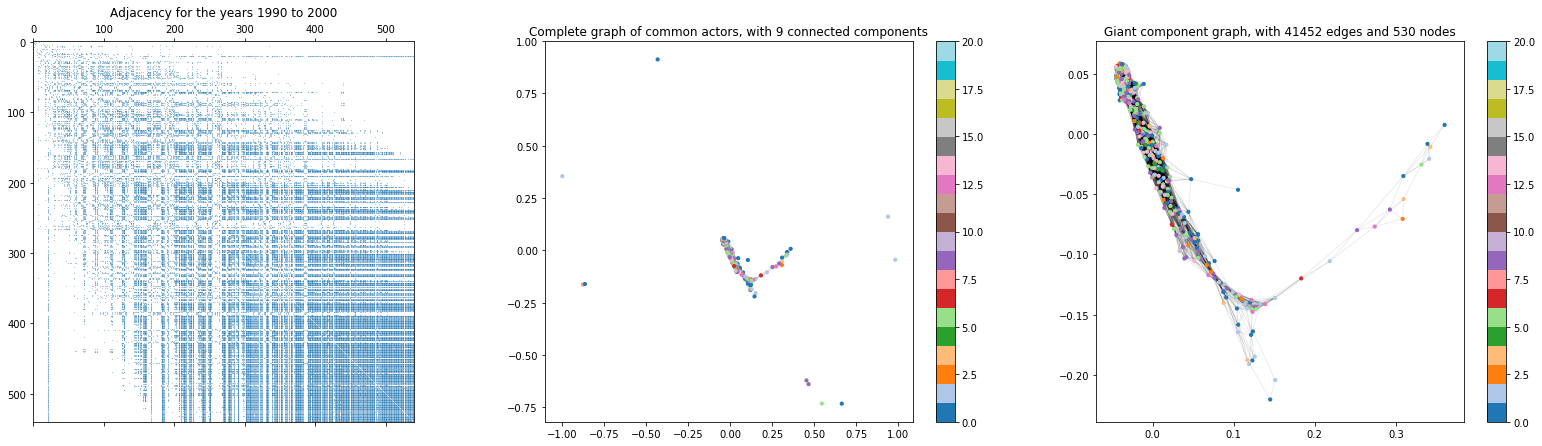

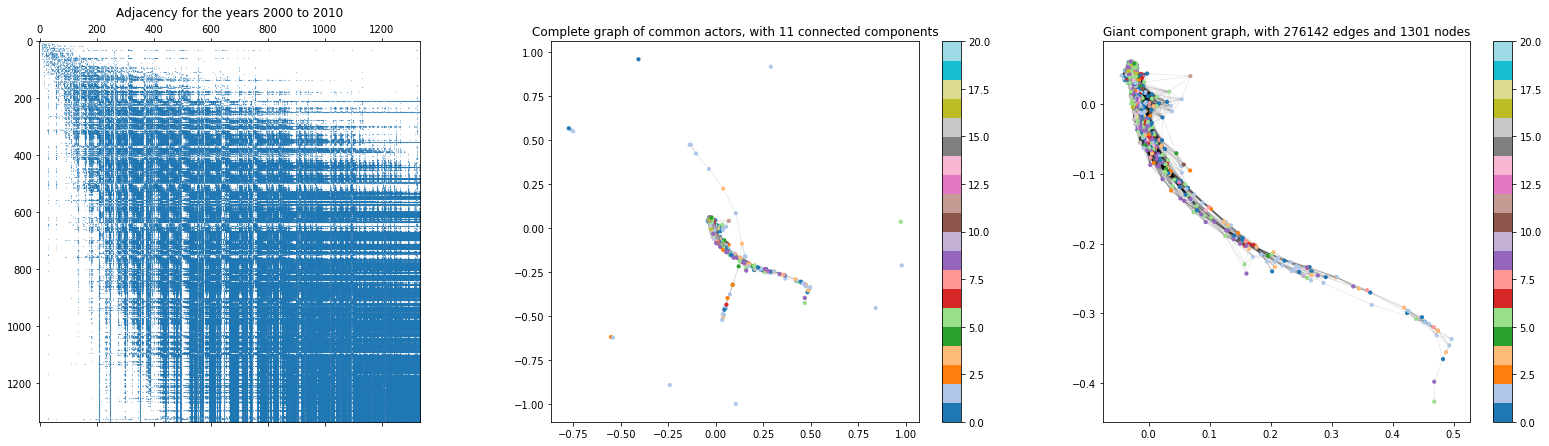

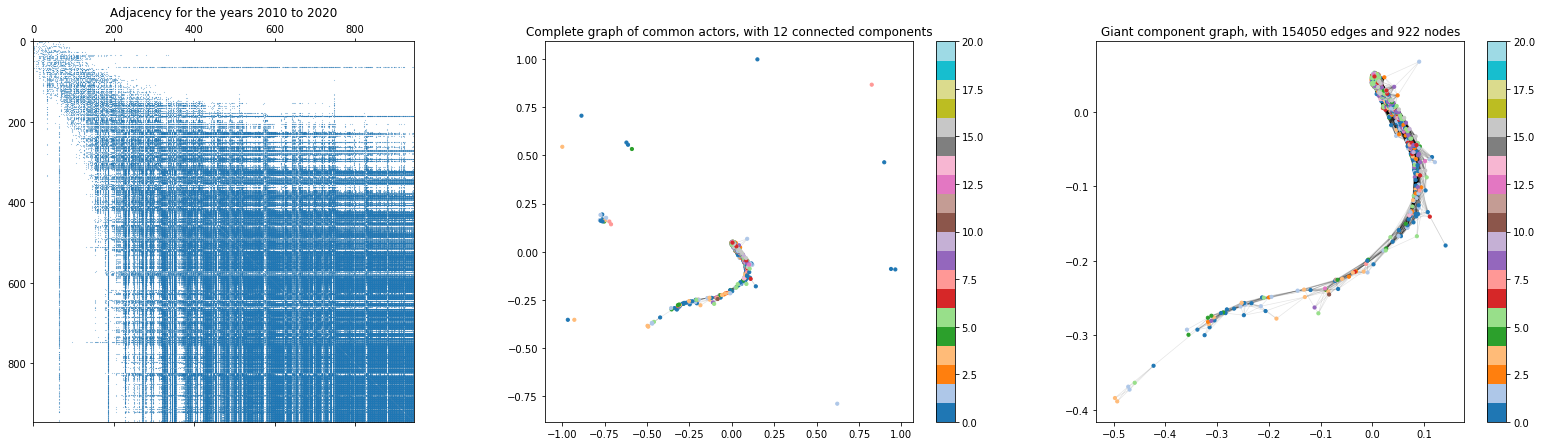

In [51]:
for i in range(numberOfDecades):
    
    decade = 1960 + i*10
    decadeEnd = decade + 10
    
    adjacencyDecade=adjacenciesFilteredByYears[i]
    G_decade=GgraphsFilteredByYears[i]
    coords_decade=CoordsSpringFilteredByYears[i]
    
    Gc_decade=GCgraphsFilteredByYears[i]
    coords_decade_Gc=CoordsSpringFilteredByYears[i]
    
    plt.figure(figsize=(28, 7))
    plt.subplot(131)
    plt.spy(adjacencyDecade, markersize=0.1)
    plt.title('Adjacency for the years {} to {}'.format(decade, decadeEnd))   
    
    labels = moviesFilteredByYears[i]['genres'].iloc[np.sort(nx.nodes(G_decade))]
    plt.subplot(132)
    im=nx.draw_networkx_nodes(G_decade, coords_decade, node_size=10,node_color=labels, cmap='tab20',vmin=0, vmax=20)
    nx.draw_networkx_edges(G_decade, coords_decade, alpha=0.1, width=0.7)
    plt.title('Complete graph of common actors, with {} connected components'.format(nx.number_connected_components(G_decade)))
    plt.colorbar(im);
    
    nb_edges_gc=Gc_decade.number_of_edges()
    nb_nodes_gc=Gc_decade.number_of_nodes()
    labels = moviesFilteredByYears[i]['genres'].iloc[np.sort(nx.nodes(Gc_decade))]
    plt.subplot(133)
    im=nx.draw_networkx_nodes(Gc_decade, coords_decade_Gc, node_size=10,node_color=labels, cmap='tab20',vmin=0, vmax=20)
    nx.draw_networkx_edges(Gc_decade, coords_decade_Gc, alpha=0.1, width=0.7)
    plt.title('Giant component graph, with {} edges and {} nodes'.format(nb_edges_gc,nb_nodes_gc))
    plt.colorbar(im);

Then, by using these giant components graphs, we can plot different signals on them and compare them. Below are the budget in comparison with the movie genre. We can see that there are no communities formed by the movie genres.

C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab

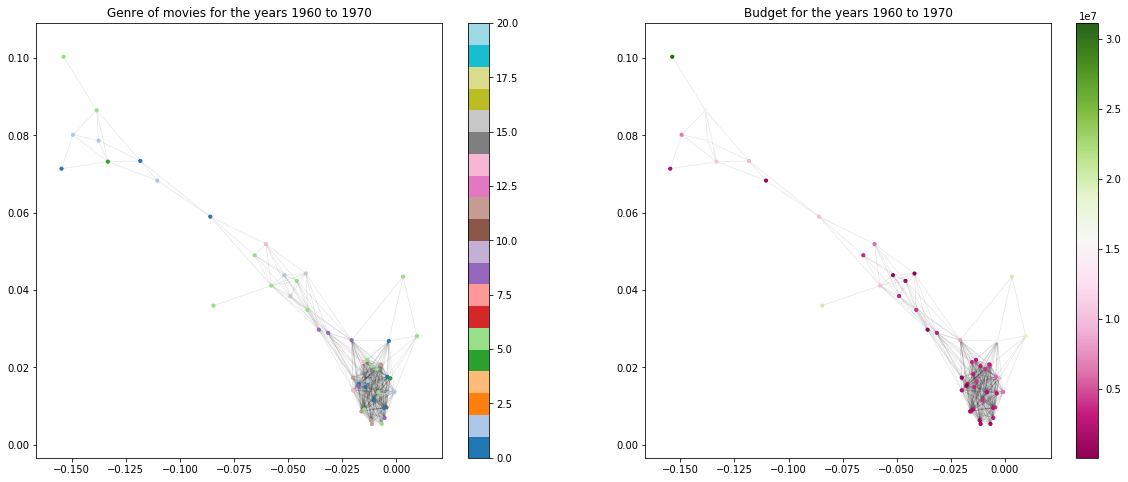

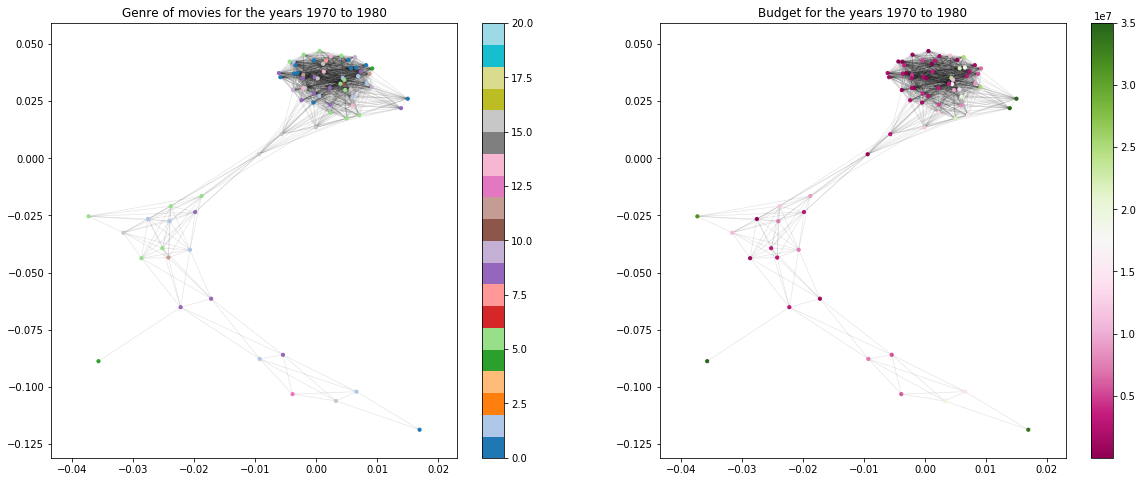

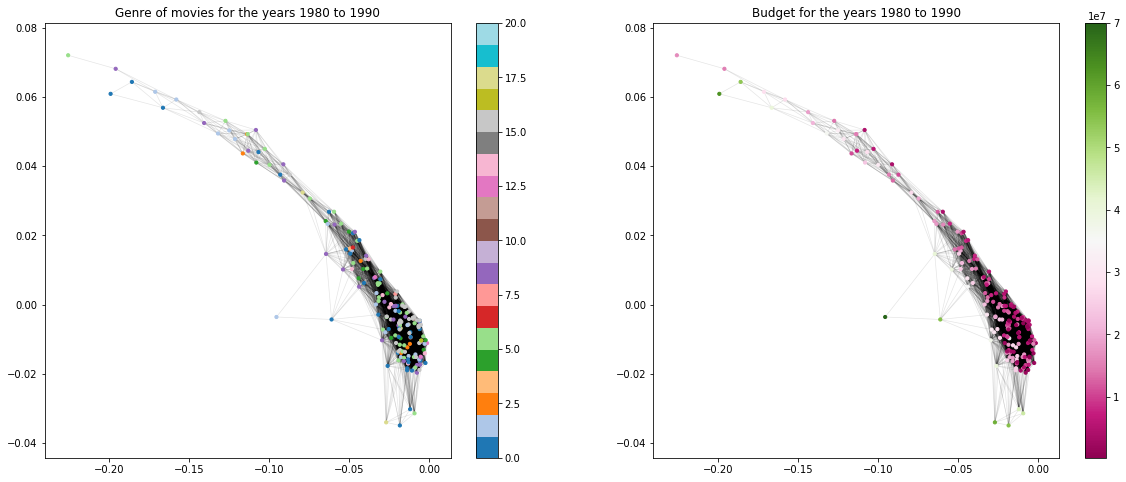

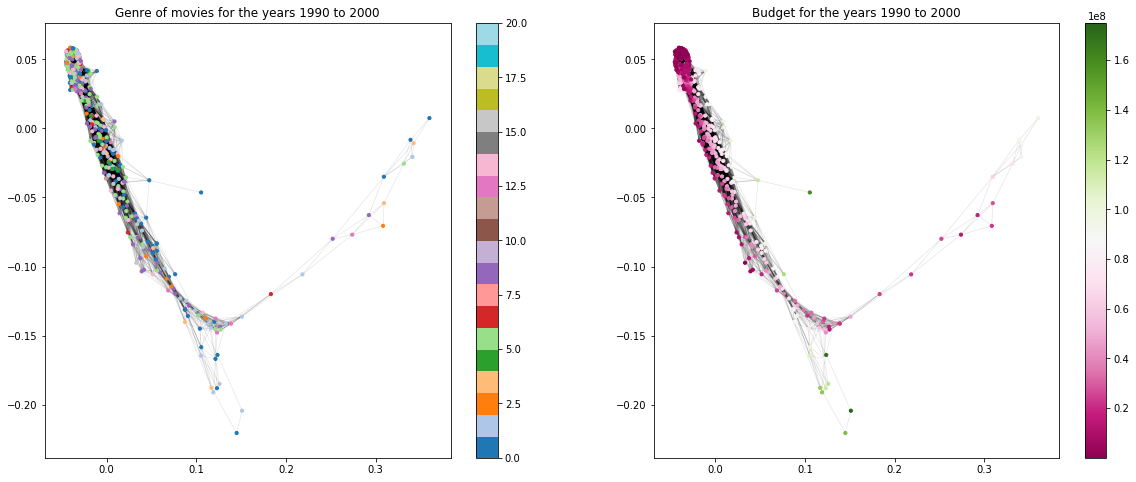

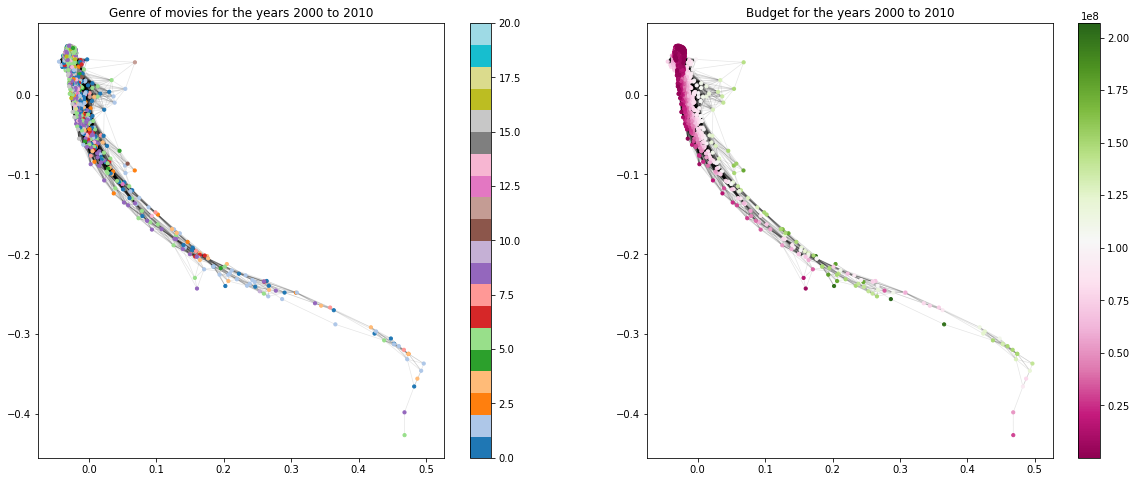

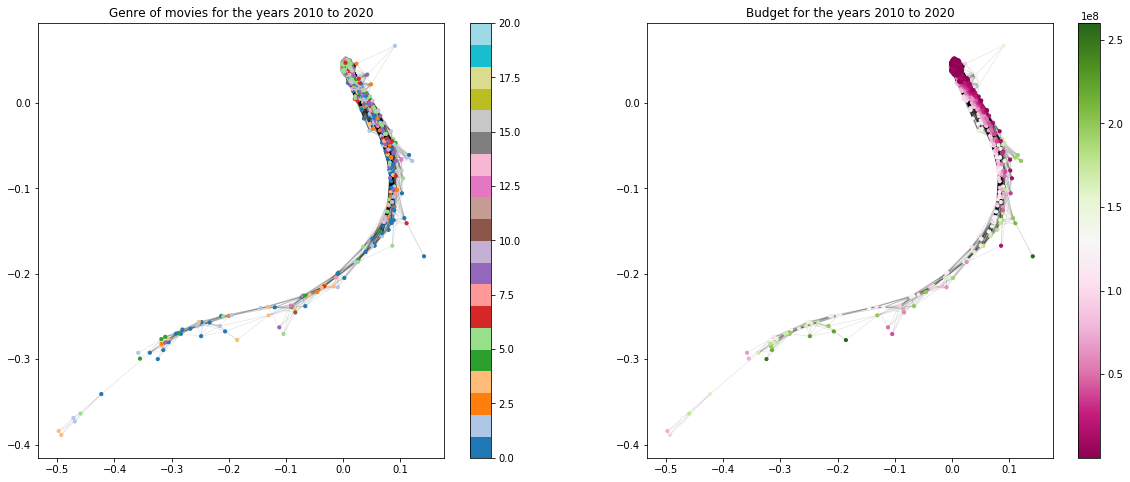

In [52]:
i = 0
for G in GCgraphsFilteredByYears:
    
    decade = 1960 + i*10
    decadeEnd = decade + 10
    
    plt.figure(figsize=(20, 8))
    
    plt.subplot(121)
    labels = moviesByBudgetFilteredByYears[i]['genres'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='tab20',vmin=0, vmax=20)
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Genre of movies for the years {} to {}'.format(decade,decadeEnd))
    plt.colorbar(im);
    
    plt.subplot(122)
    labels = moviesByBudgetFilteredByYears[i]['budget'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Budget for the years {} to {}'.format(decade,decadeEnd))
    plt.colorbar(im);
        
    i=i+1
    

#### Here we can look at the budget and the revenue together.
This allows us to better observe the correlation that exist between them.

C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab

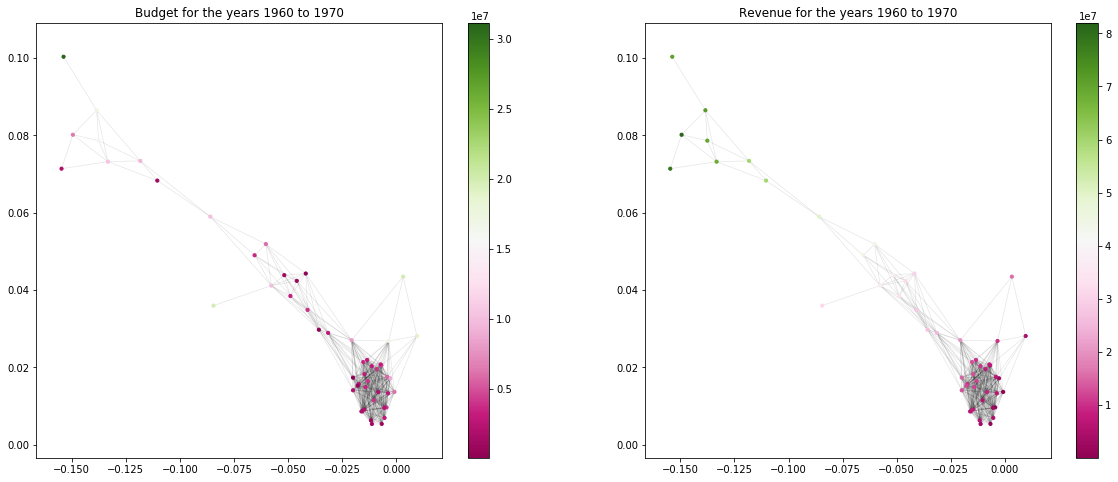

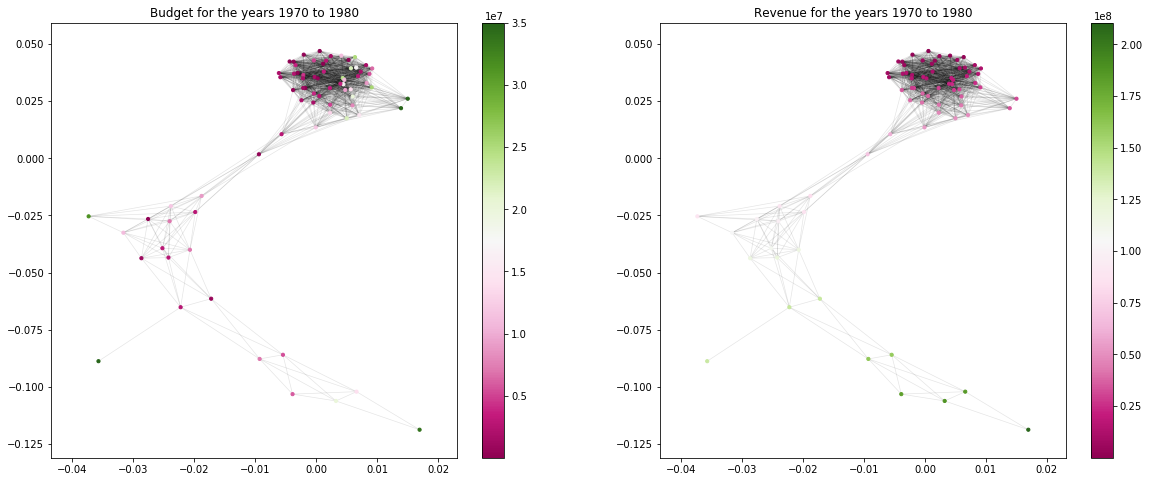

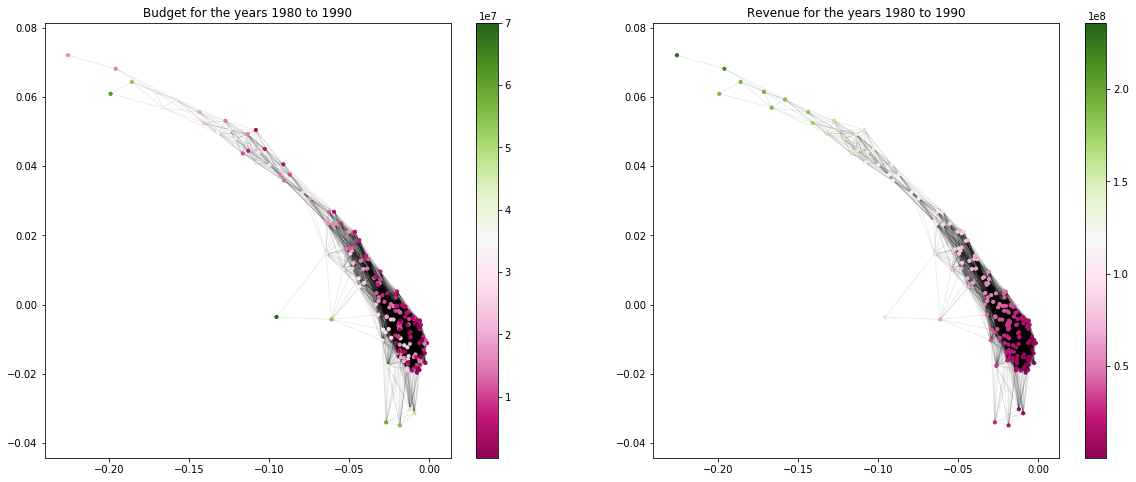

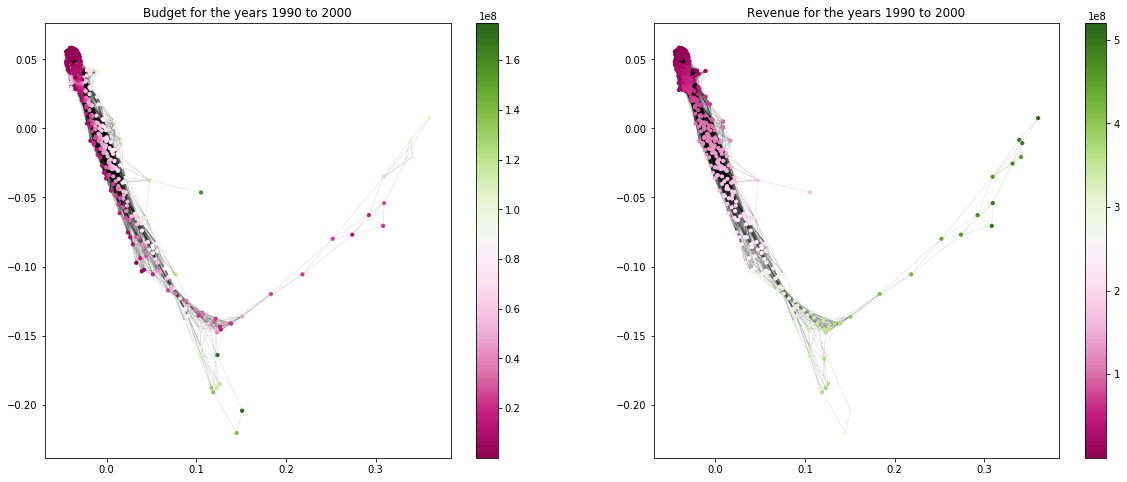

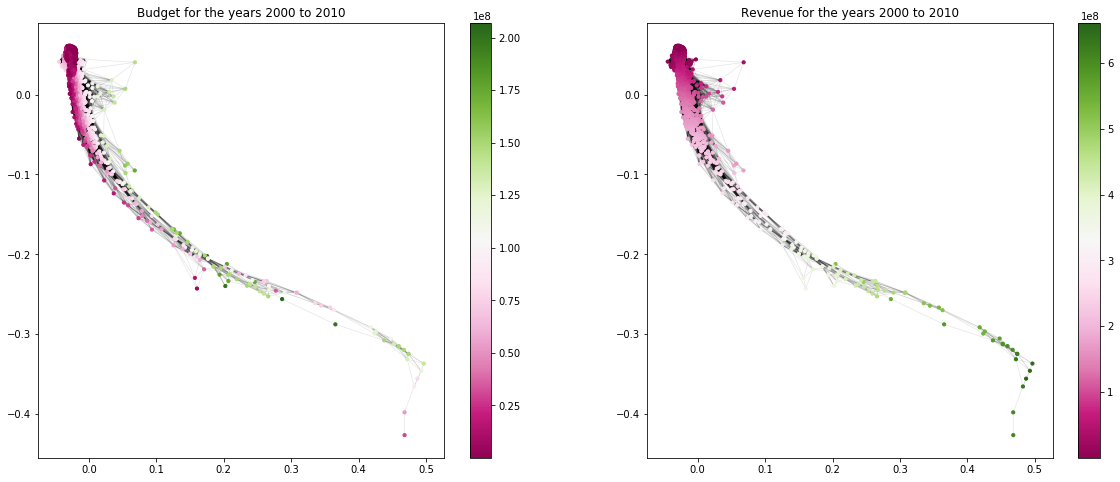

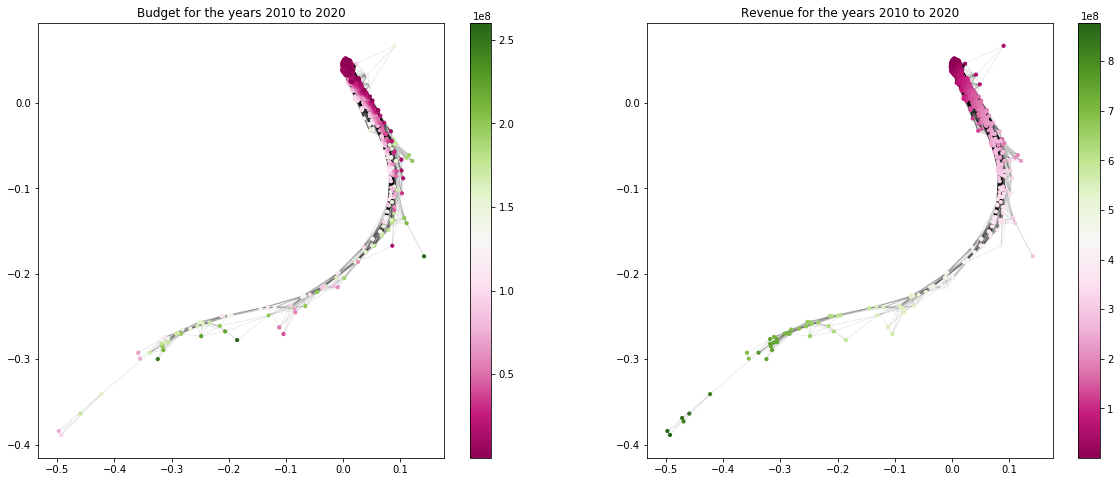

In [53]:
i = 0
for G in GCgraphsFilteredByYears:
    
        
    decade = 1960 + i*10
    decadeEnd = decade + 10
    
    plt.figure(figsize=(20, 8))
    plt.subplot(121)
    labels = moviesByBudgetFilteredByYears[i]['budget'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Budget for the years {} to {}'.format(decade,decadeEnd), fontsize=12)
    plt.colorbar(im);
    
    plt.subplot(122)
    labels = moviesByBudgetFilteredByYears[i]['revenue'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Revenue for the years {} to {}'.format(decade,decadeEnd),fontsize=12)
    plt.colorbar(im);
        
    i=i+1

#### Finaly we can look at the budget and the vote average.
We can see that the vote average is not dependent on the budget, as the ratings are similar in the entire graph.

C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab

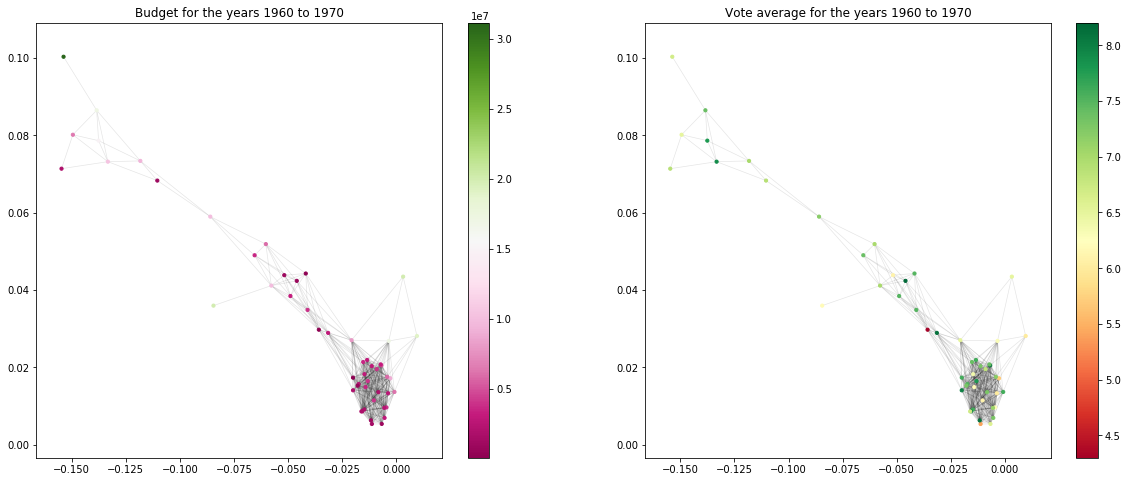

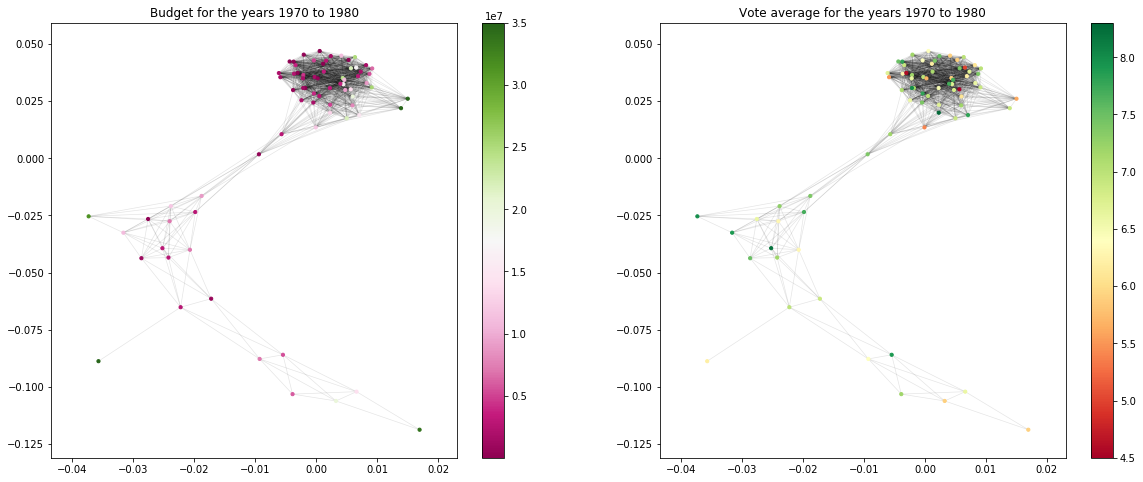

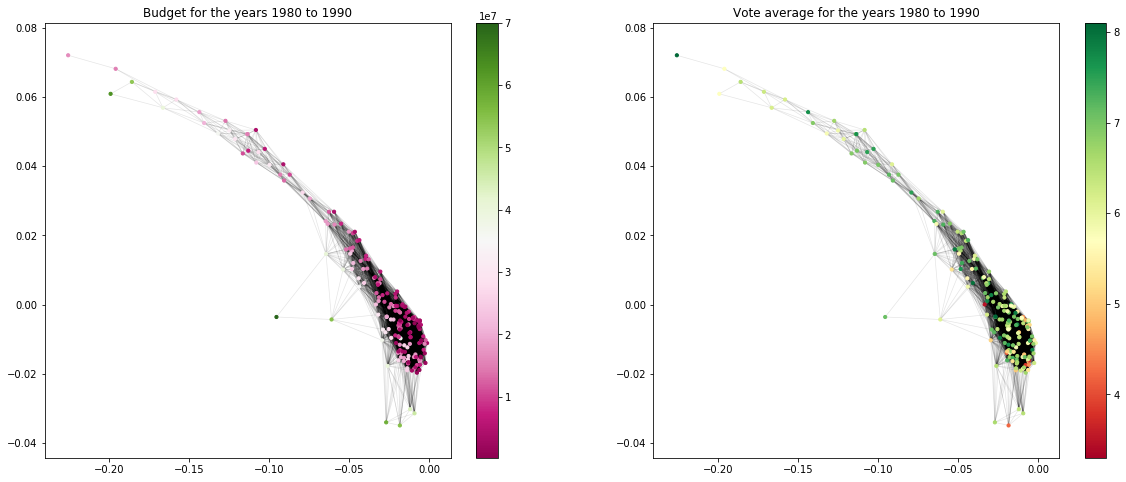

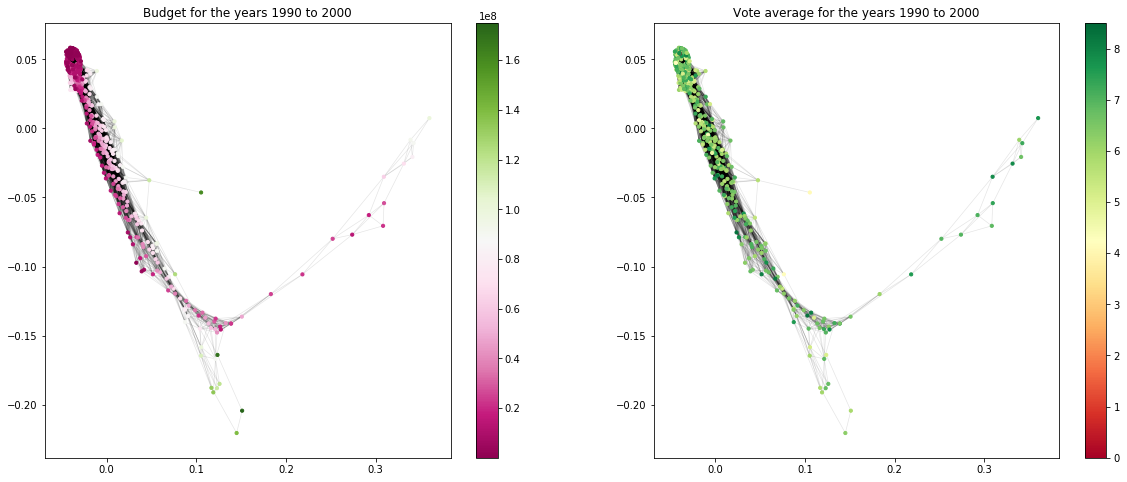

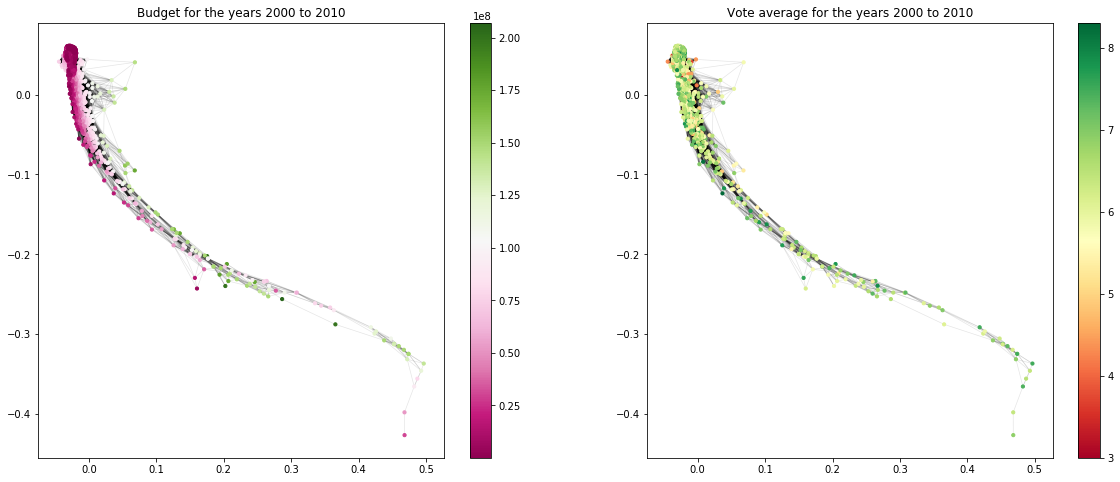

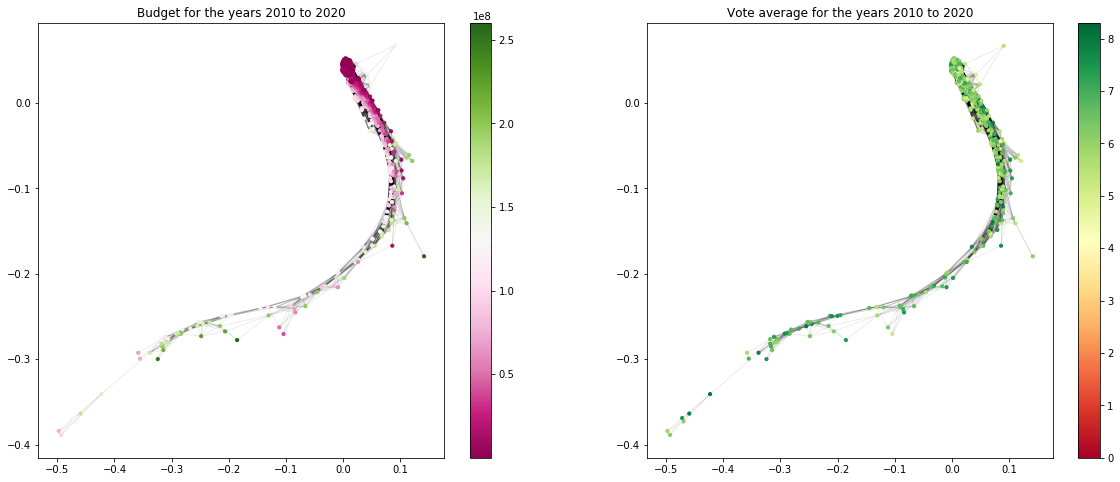

In [54]:
i = 0
for G in GCgraphsFilteredByYears:
    
    decade = 1960 + i*10
    decadeEnd = decade + 10
    
    plt.figure(figsize=(20, 8))
    plt.subplot(121)
    labels = moviesByBudgetFilteredByYears[i]['budget'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Budget for the years {} to {}'.format(decade,decadeEnd))
    plt.colorbar(im);
    
    plt.subplot(122)
    labels = moviesByBudgetFilteredByYears[i]['vote_average'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='RdYlGn')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Vote average for the years {} to {}'.format(decade,decadeEnd))
    plt.colorbar(im);
        
    i=i+1

#### As we considered the success rate, we can also look at it next to the budget.
Here we can see that overall, movies with large budgets are all successfull, meaning that they are able to obtain a revenue of at least 150% of their budget. 

C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\Users\Mathieu\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab

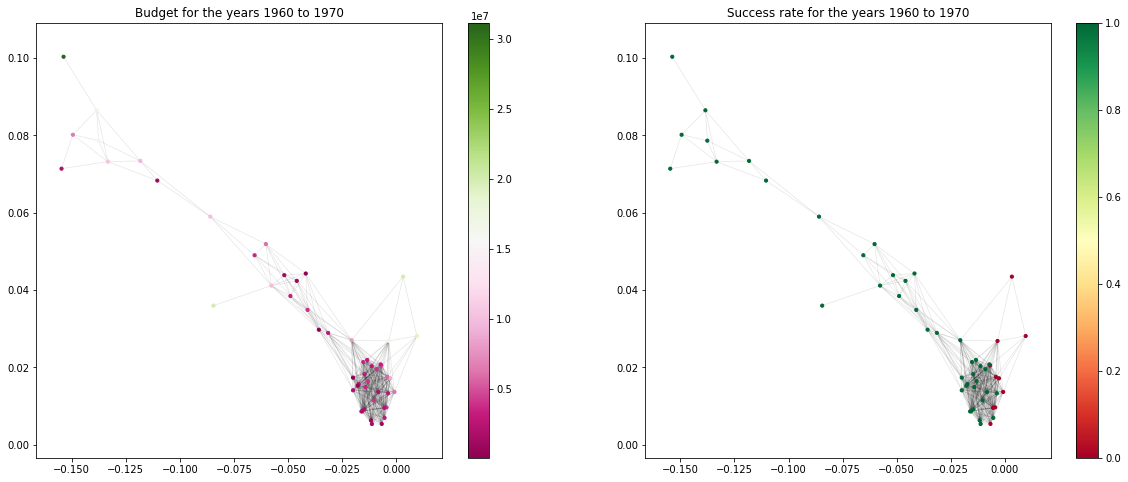

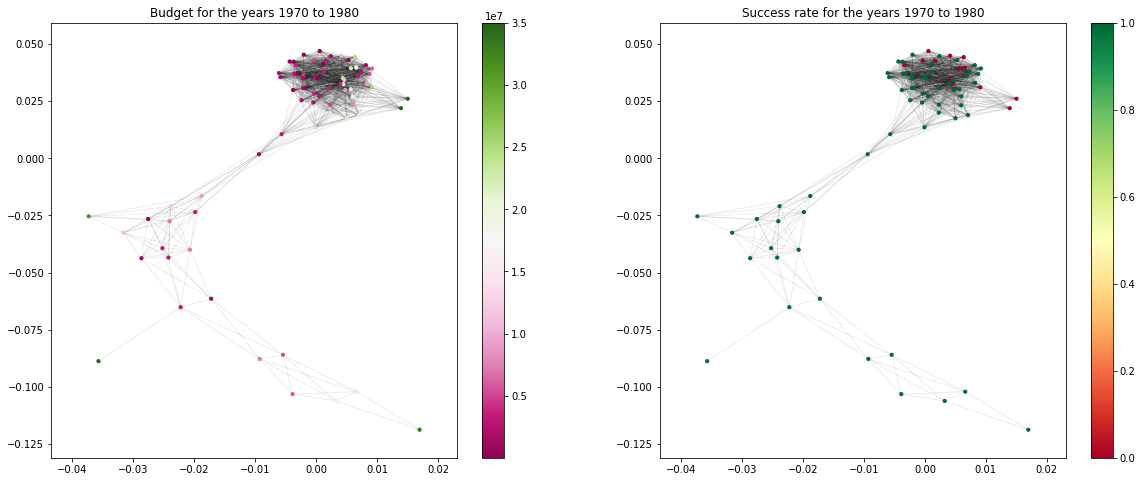

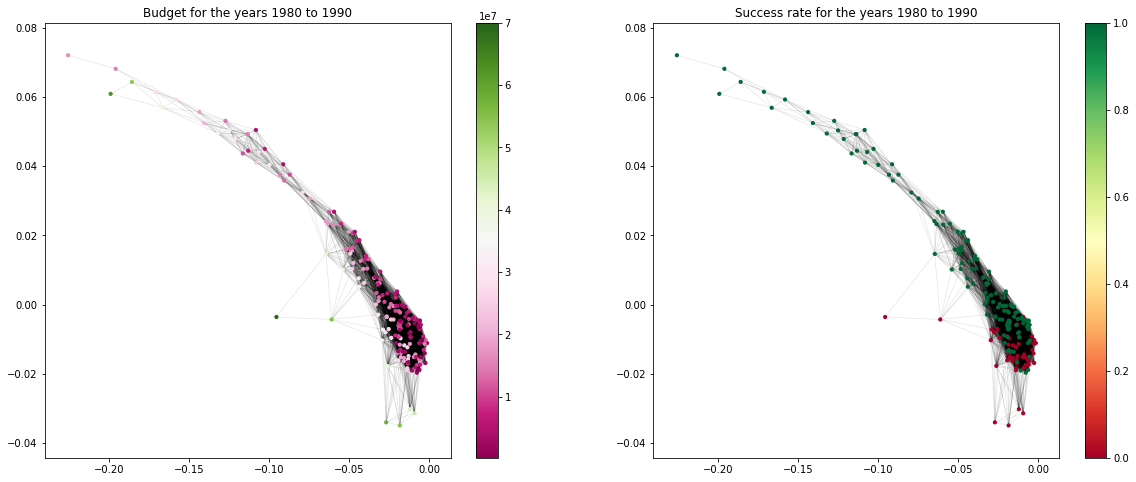

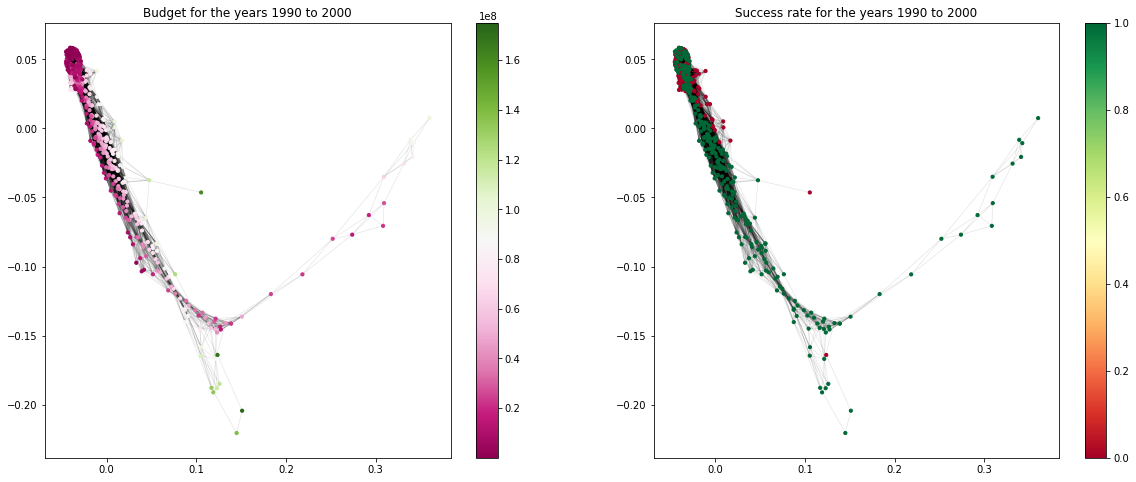

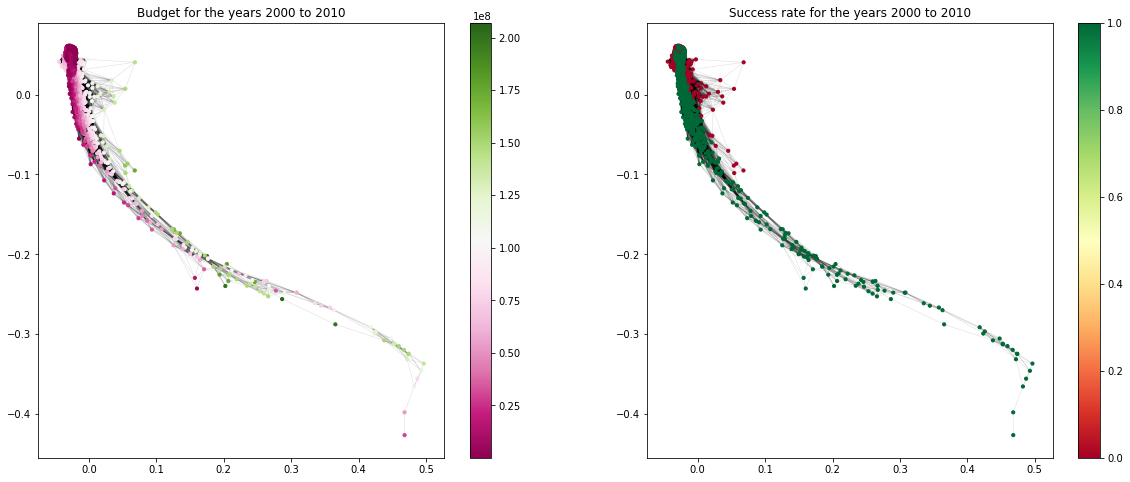

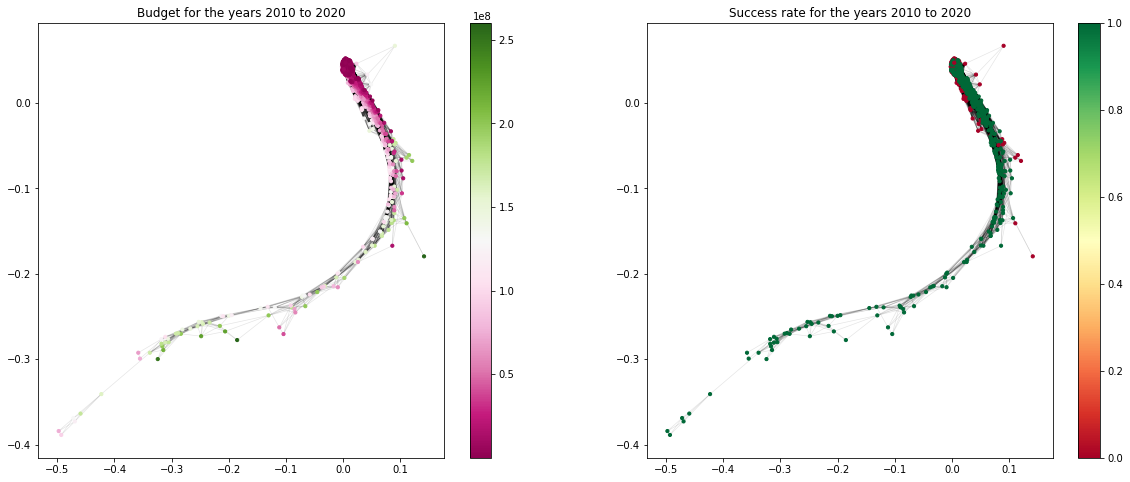

In [55]:
i = 0
for G in GCgraphsFilteredByYears:
    
    decade = 1960 + i*10
    decadeEnd = decade + 10
    
    plt.figure(figsize=(20, 8))
    plt.subplot(121)
    labels = moviesByBudgetFilteredByYears[i]['budget'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='PiYG')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Budget for the years {} to {}'.format(decade,decadeEnd))
    plt.colorbar(im);
    
    plt.subplot(122)
    labels = moviesByBudgetFilteredByYears[i]['success'].iloc[np.sort(nx.nodes(G))]
    coords_spring=CoordsSpringFilteredByYears[i]
    im=nx.draw_networkx_nodes(G, coords_spring, node_size=10, node_color=labels, cmap='RdYlGn')
    nx.draw_networkx_edges(G, coords_spring, alpha=0.1, width=0.7)
    plt.title('Success rate for the years {} to {}'.format(decade,decadeEnd))
    plt.colorbar(im);
        
    i=i+1